# Intracranial Hemorrhage (ICH) Classification Report
The purpose of this report is to perform multilabel classification on a series of 8,542 train images of brain CT scans, and have it evaluated on 4,019 test images. The primary strategy will be to utilize transfer learning on a model previously trained on a much larger corpus of image data. The conditions being analyzed are Epidural, Intraparenchymal, and Subarachnoid. This is multilabel classification in that a single image can present more than one type of ICH, and it is also possible a single image possesses none of these conditions. The main intention of this report is to not only produce a high quality model, but walk through the model and methods used for training, explaining the justification behind the choices made, and analyze the obtained results and discuss potential next steps to improve performance.

#### Import libraries
Note that we are importing both common libraries and custom ones I have refactored code into.

In [1]:
import sys
sys.path.append('venv/lib/python3.7/site-packages')
import numpy as np
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from albumentations import HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate, Resize, CenterCrop, Compose
from albumentations.pytorch import ToTensor
from sklearn.metrics import multilabel_confusion_matrix, classification_report, hamming_loss
from sklearn.dummy import DummyClassifier
import torch
from prettytable import PrettyTable

import utils
from classes.color import color
from classes.dataset import ImageDataset
from classes.model import FineTuneTrainer
from classes.ResNeXt import ResNeXt

#### Set global constants
These are settings that can be tweaked to adjust how the model trains/runs on your own computer.

In [2]:
NUM_EPOCHS = 35  # Number of full pass-throughs of the data set in training
VAL_FREQ = 1  # Number of epochs after which to run a validation
LR = 2e-6  # Learning rate for optimizer
EARLY_STOPPING_PATIENCE = 5  # Number of epochs with no improvement to stop training after
DEVICE = 'cuda:0'  # Set to my one gpu
BATCH_SIZE = 32  # Number of images to simultaneously load onto the GPU. Bottlenecked by GPU RAM limitations.
GRAD_ACCUM_STEPS = 2  # Increases effective batch size by a multiplier of this value
NUM_WORKERS = 16  # Multiprocessing for loading data onto the gpu
NUM_CLASSES = 3  # There are three distinct conditions being modeled in this exercise
CSV_FILE = 'data/wetransfer-1c7414/behold_coding_challenge_train.csv'  # Image folder containing training data
RANDOM_STATE = 0  # For reproducibility of random splits

## Exploratory Data Analysis
My deep learning framework of choice is PyTorch. I prefer PyTorch over Tensorflow/Keras because of how straightforward it is to play with low level components of the graph, while still being able to write short, efficient code. TF2.0 has improved on this in the past year, but I still strongly prefer PyTorch.

The first stage in conducting EDA with PyTorch is to build a custom data set class. A custom data set class allows fine control over how the data is preprocessed and loaded into memory for training on the GPU. This allows for data augmentation, preprocessing the dimensions of the image, and various util functions for retrieving and visualizing data.

### Train / Validation Split
Before loading data into memory, a classic train / validation split stratified by distribution of labels is performed. A random seed for reproducibility of splits is set:

In [3]:
train_indices, val_indices = utils.train_val_split(csv_file=CSV_FILE, test_prop=0.25, random_state=RANDOM_STATE)
print(f'Training set size is {len(train_indices)} images.')
print(f'Validation set size is {len(val_indices)} images.')

Training set size is 6406 images.
Validation set size is 2136 images.


### Training data augmentations and preprocessing
The next order of business is to perform augmentations and transformations on the training data.

The operations being performed start with resizing the data and cropping it to be 224x224, which is the image size the pretrained model of choice, ResNeXt, accepts. 

Next, we perform random horizontal flipping, random brightness contrast, and random translation, scales, and rotations of the data. The idea behind data augmentation is to slightly alter the images such that to a human the image is the same, but to a neural network the image is completely different, in that the absolute position of each pixel is changed significantly. Training the neural network to understand that this different orientation of pixels is the same label can help increase its robustness to noise. This step also acts to effectively increase the number of images in our data set, and helps reduce the effect of the neural network memorizing images in the training data set.

Note: I originally normalized the image pixels exactly how the authors of ResNeXt normalized their images, but this resulted in images that were difficult to see. I attribute this difference to the domain difference between the domain ResNeXt was trained on (ImageNet, over a million images of animals) and the domain we will be training on (brain CT scans).

In [4]:
training_transform = Compose([
    Resize(256, 256),
    CenterCrop(224, 224),
    HorizontalFlip(),
    RandomBrightnessContrast(),
    ShiftScaleRotate(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # based on: https://pytorch.org/hub/pytorch_vision_resnext/
    ToTensor(),
])

#### Instantiate custom training data set and corresponding data loader
The data loader allows control over batch size, whether to shuffle the data, and the number of workers to use. If you are trying this on your own and do not have 16 cpu cores, I recommend going back and changing the number of workers to a more suitable number for your hardware.

In [5]:
training_data = ImageDataset(idxs=train_indices.values,
                             csv_file=CSV_FILE,
                             root_dir='data/wetransfer-1c7414/train_images',
                             transform=training_transform)

train_loader = DataLoader(training_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

print(f'Length of training data is {len(training_data)} images, while length of epoch is {len(train_loader)}'
      f' batches of {BATCH_SIZE} images each.')

Length of training data is 6406 images, while length of epoch is 201 batches of 32 images each.


#### Instantiate custom validation data set and corresponding data loader
Next, we instantiate the validation data set. Note that we are not going to perform the data augmentation in this step and will only perform the steps necessary to load the images in and hook it up to ResNeXt appropriately. We will also not bother shuffling the data in our validation data loader.

In [6]:
val_transform = Compose([
    Resize(256, 256),
    CenterCrop(224, 224),
    ToTensor(),
])
val_data = ImageDataset(idxs=val_indices.values,
                        csv_file=CSV_FILE,
                        root_dir='data/wetransfer-1c7414/train_images',
                        transform=val_transform)

val_loader = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS)

print(f'Length of validation data is {len(val_data)} images, while length of epoch is {len(val_loader)}'
      f' batches of {BATCH_SIZE} images each.')

Length of validation data is 2136 images, while length of epoch is 67 batches of 32 images each.


We also want to set aside the true labels from the validation set to use for model selection in a later portion of this report:

In [7]:
y_true = val_data.labels.iloc[:, 1:].values

### Visualizing the data set
Now that we are all set up to load in data, we can visualize our data set to try to get a better understanding as to what is going on.

We will begin by leveraging a few util functions I wrote that will plot the distribution of data labels by condition, as well as frequency of co-occurrences of conditions to determine if there are any patterns we should
note before attempting to build a model. If it is noted that a dependency exists between labels, it may be prudent to employ a sequence-learning network architecture such as RNN or attention.

Training data and validation data are analyzed separately to ensure that appropriate stratification occurred.

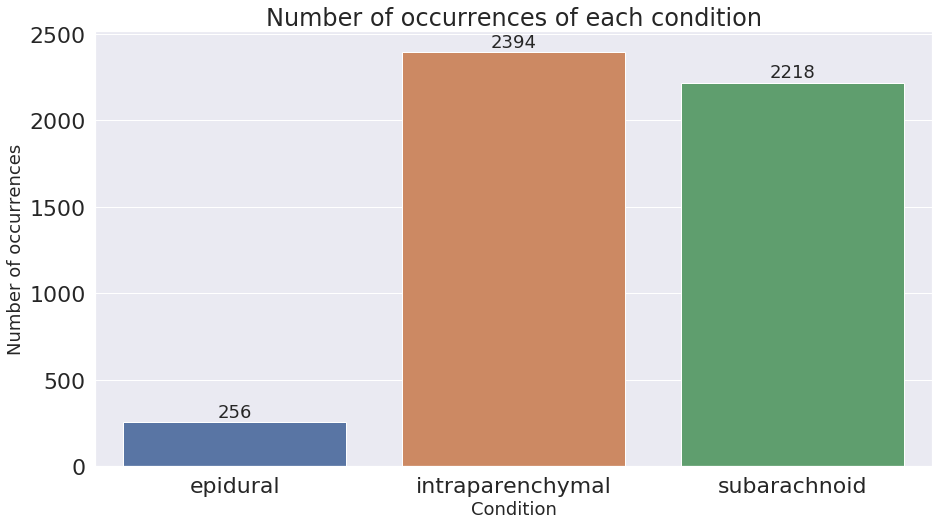

In [8]:
utils.bar_plot_condition_occurrences(training_data.labels)

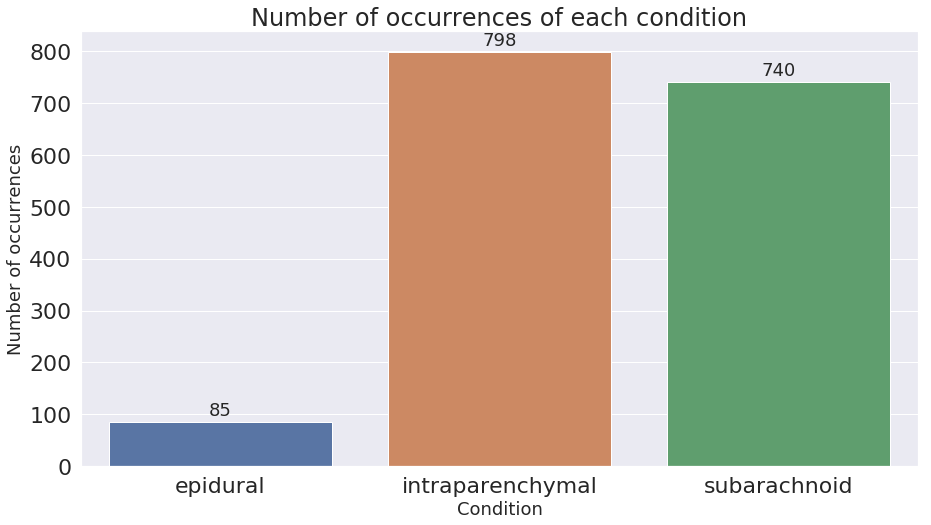

In [9]:
utils.bar_plot_condition_occurrences(val_data.labels)

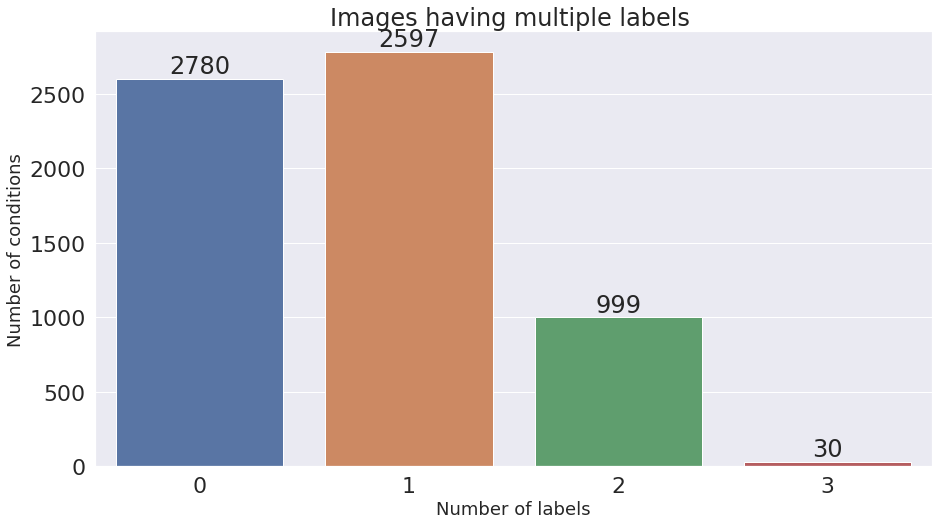

In [10]:
utils.bar_plot_condition_co_occurrences(training_data.labels)

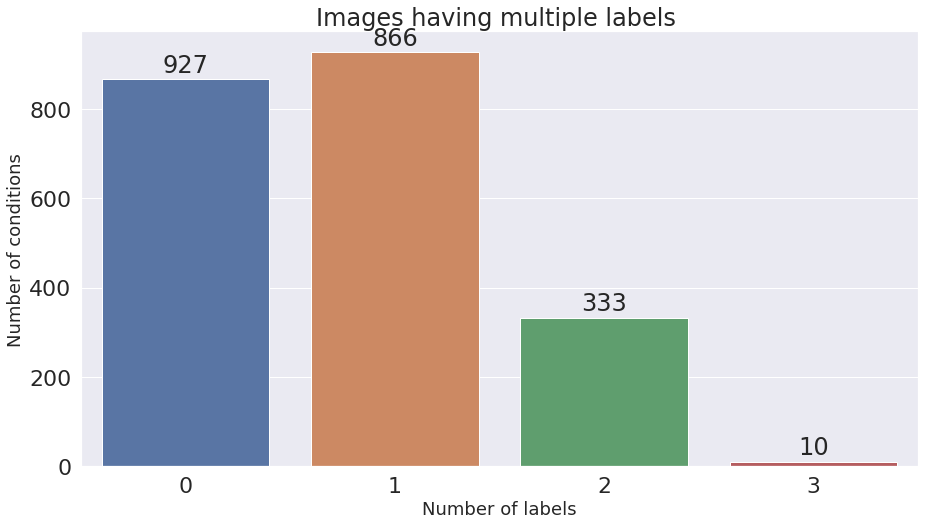

In [11]:
utils.bar_plot_condition_co_occurrences(val_data.labels)

The important takeaways from these plots is that we have a rather imbalanced class compared to the other two. This class is epidural. It only occurs in about 4% of images, whereas the other two classes occur around 36% of the time. Also, the majority of images have either zero or a single label, and infrequently we see combinations of conditions. 

The next thing to test will be whether these conditions are independent or depend on one another. We can do this via a chi-squared test, as well as a cramer's V statistic, which measures correlation between categorical variables.

In [12]:
print(f"The chi-squared p-value statistic between epidural and intraparenchymal is {utils.get_chi2_p_value(training_data.labels.epidural, training_data.labels.intraparenchymal):.3f} and the cramer's V correlation is {utils.cramers_v(training_data.labels.epidural, training_data.labels.intraparenchymal):.3f}.")
print(f"The chi-squared p-value statistic between epidural and subarachnoid is {utils.get_chi2_p_value(training_data.labels.epidural, training_data.labels.subarachnoid):.3f} and the cramer's V correlation is {utils.cramers_v(training_data.labels.epidural, training_data.labels.subarachnoid):.3f}.")
print(f"The chi-squared p-value statistic between subarachnoid and intraparenchymal is {utils.get_chi2_p_value(training_data.labels.subarachnoid, training_data.labels.intraparenchymal):.3f} and the cramer's V correlation is {utils.cramers_v(training_data.labels.subarachnoid, training_data.labels.intraparenchymal):.3f}.")

The chi-squared p-value statistic between epidural and intraparenchymal is 0.062 and the cramer's V correlation is 0.020.
The chi-squared p-value statistic between epidural and subarachnoid is 0.015 and the cramer's V correlation is 0.028.
The chi-squared p-value statistic between subarachnoid and intraparenchymal is 0.000 and the cramer's V correlation is 0.073.


Conclusion: It's unlikely that there is much interaction going on between these conditions, so in the absence of any clinical rationale for modeling interactions, we will not spend additional time considering this possibility.

### Visual inspection of data
It's also interesting to do a quick visual inspection of the data. I'm not a trained doctor, but it would be interesting to see if a quick visual inspection can identify differences in classes. I've built out a few convenience functions to show individual images, as well as collect examples of a single type to do quick comparisons against one another. Feel free to change the inputs to play around with it!

Let's compare various labels to see if we can visually identify differences:

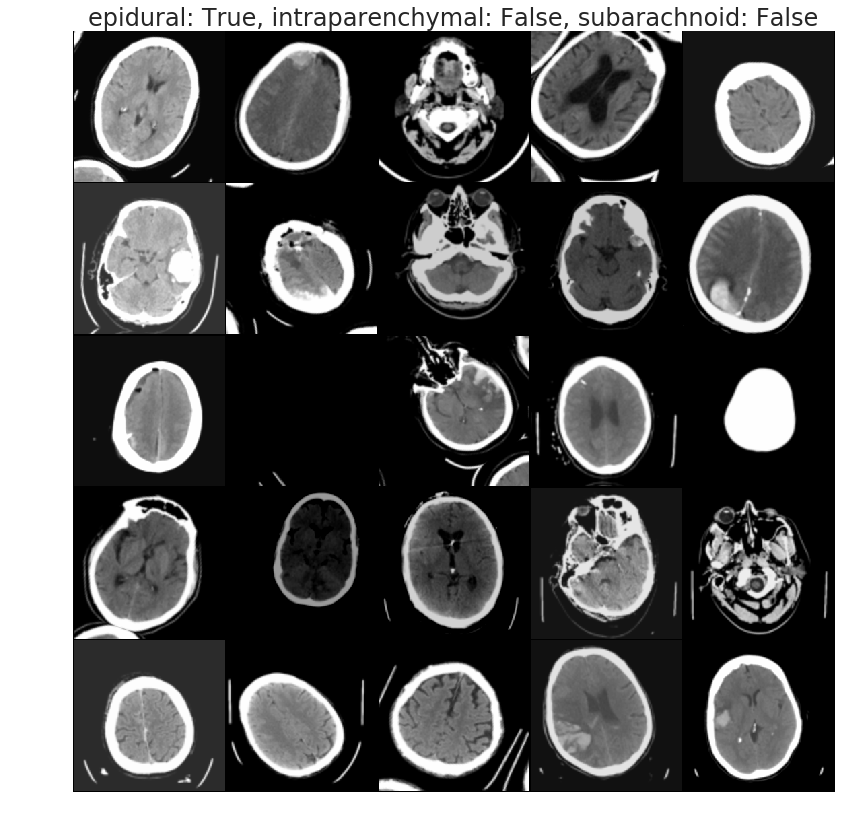

In [13]:
training_data.show_grid(label=[1, 0, 0], num_examples=25)

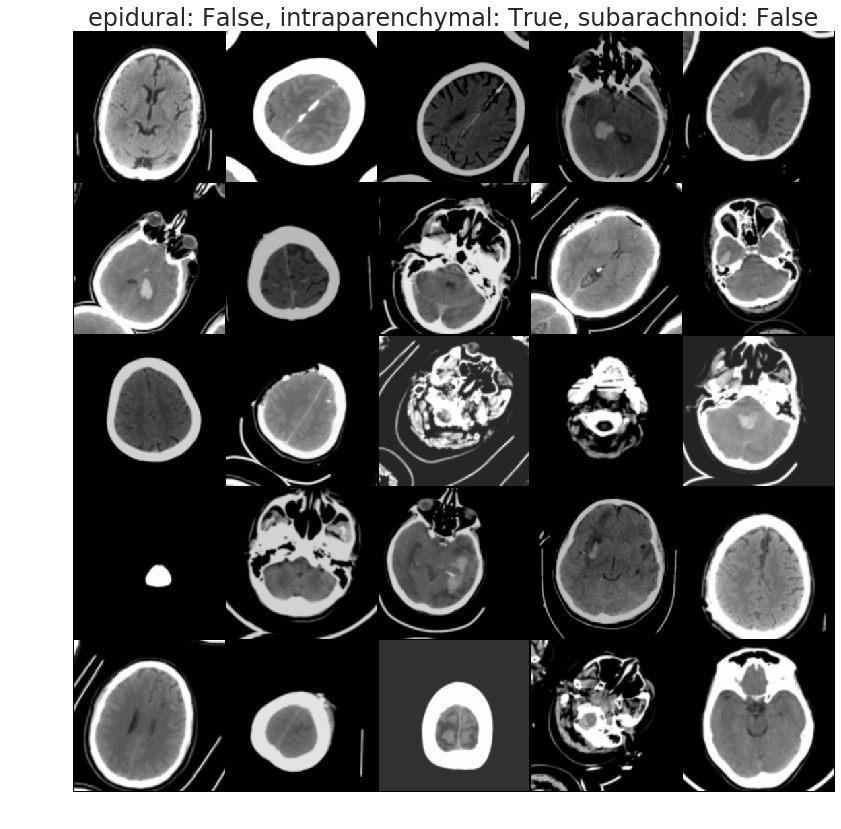

In [14]:
training_data.show_grid(label=[0, 1, 0], num_examples=25)

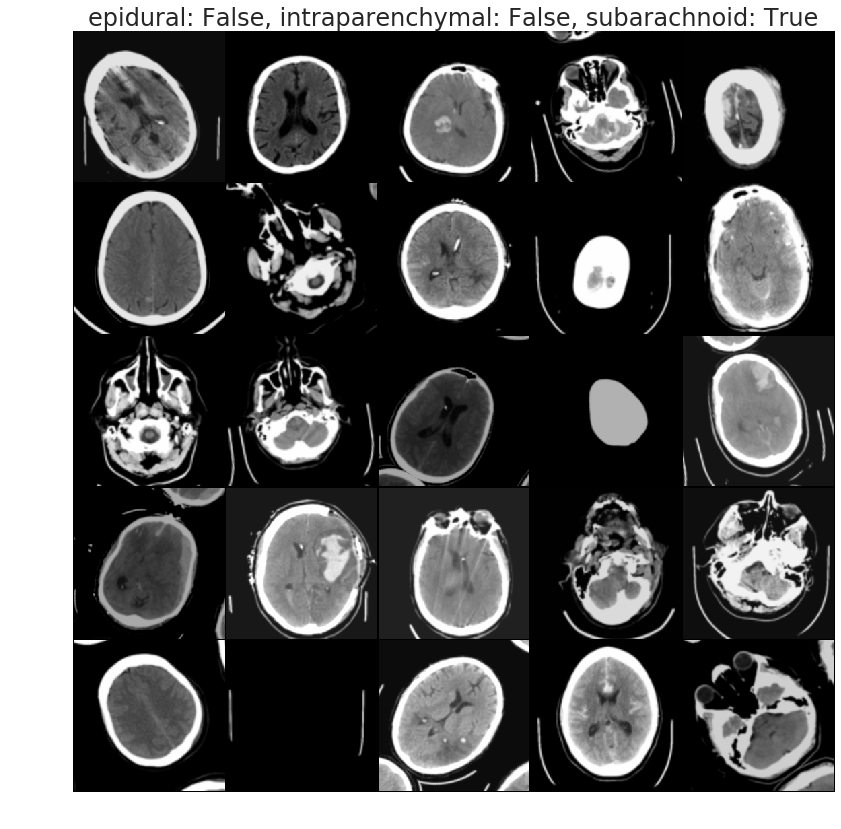

In [15]:
training_data.show_grid(label=[0, 0, 1], num_examples=25)

I don't think there is much chance I have at easily identifying whether these conditions are present, but we utilize GradCAM further along on our trained models to see if we can uncover any patterns not immediately obvious to the untrained human eye.

We can also repeatedly generate the same image to get a good idea how our augmentations are handling our data. Feel free to play around with it to generate various images of various types to get a good understanding of the data augmentation taking place:

Label for image idx 10 is [1 1 0]


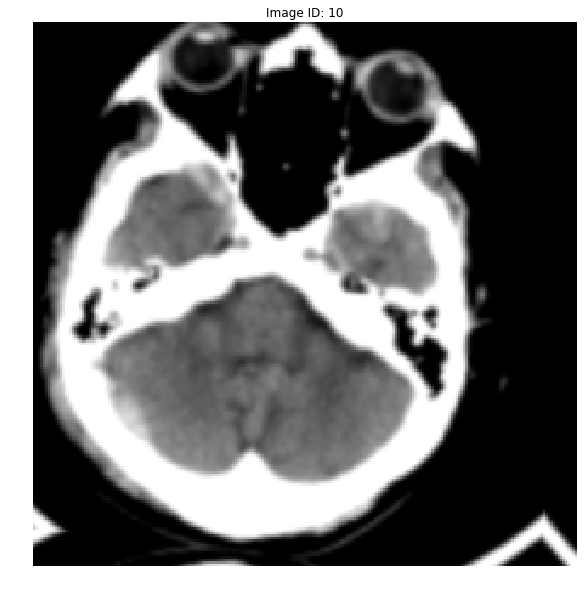

In [16]:
idx = 10
print(f'Label for image idx {idx} is {training_data.labels.iloc[idx, 1:].values}')
training_data.show_image(idx)

## Baseline Models
The next step will be to set up a few baseline models against which we can compare our results and discuss the metrics to use to compare model performance. 

In the absence of specific instructions as to whether certain conditions are more important to identify than other conditions, I assume that identifying each condition is equally important. Another important consideration is whether it is more important to optimize precision vs. recall. Generally, when diagnosing conditions in the medical field, one would seek to optimize recall over precision because false negatives are more costly than false positives. Furthermore, due to the class imbalance noted earlier, it will make more sense to optimize the micro avg rather than the macro avg (macro avg treats all classes as having the same frequency, whereas micro weights the classes based on their actual frequency, and we are assuming that all classes are equally important regardless of their frequency of occurrence). Therefore, we will use the micro avg recall as the primary metric of interest, but also take note of other metrics such as F1 score and Hamming loss, because we don't want to completely ignore the issue of false positives. I will also be displaying one vs. all confusion matrices for each condition in the order of epidural, intraparenchymal, and subarachnoid. Another interesting statistic is Hamming loss, which is the fraction of individual labels that are incorrectly predicted. It is essentially like accuracy for single label classification, except it is not "all-or-nothing". In other words, if one label is incorrect, but the other two are correct, it only penalizes the model for the one mistake rather than all 3.

### Baseline Model #1: Dummy Classifier
The dummy classifier simply makes random predictions based on the distribution of labels it was fitted on. If a model is unable to outperform this benchmark, then it has not learned anything of value.

In [24]:
dummy_classifier = DummyClassifier(random_state=RANDOM_STATE)
dummy_classifier.fit(X=None, y=training_data.labels.iloc[:, 1:].values)
y_pred_dummy = dummy_classifier.predict(X=np.empty(len(val_data.labels)))

utils.print_model_metrics(y_pred_dummy, y_true)

Hamming Loss: 32.74%

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.08      0.07        85
           1       0.38      0.36      0.37       798
           2       0.36      0.35      0.36       740

   micro avg       0.35      0.34      0.35      1623
   macro avg       0.27      0.26      0.27      1623
weighted avg       0.35      0.34      0.35      1623
 samples avg       0.22      0.20      0.20      1623


One vs. All Confusion Matrices
[[[1955   96]
  [  78    7]]

 [[ 857  481]
  [ 508  290]]

 [[ 943  453]
  [ 482  258]]]


### Baseline Model #2: Pretrained Model as Feature Extractor
The dummy classifier model is clearly an oversimplified baseline, and we can certainly build a better baseline for later ablation studies. Since the remaining models will use the pretrained model ResNeXt, I propose using a minimally fine-tuned variant of ResNeXt as a baseline. This will entail freezing all weights in the model and training only the fully connected layer at the end. We will also not do any class weighting or over-sampling for this baseline model.

#### Discussion of the model
From here on out, we will be using the pretrained model ResNeXt and training variations of it in order to select a final "best" model. I put together a simple class structure in the code underlying this notebook. You are welcome to check out the code yourself, but essentially it contains the following:
1. FineTuneTrainer - This class is a helper class to encapsulate the model we are training along with helper functions to freeze the model's weights and train the model in a manner that is conducive to conducting repeated experiments. History is also stored with this model so we can plot training curves afterward.
2. ResNeXt - This class is a peeled apart version of ResNeXt that can be used to leverage Gradient Class Activation Mapping (GradCAM) to better understand the model's outputs and troubleshoot weak points.
3. ImageDataset - This class has been discussed earlier, but contains an important functionality that has not been discussed yet - the ability to oversample under-represented classes.

#### Preparing the model for training
The requirements to train a model under this custom framework is a loss function, the pretrained model, and to freeze the weights we are interested in freezing. 

We will be using binary cross-entropy as the loss function due to this being a multi-label classification problem. Categorical cross-entropy would be inappropriate due to it squishing the outputs across categories to sum to one. Binary cross-entropy treats each class independently, which is appropriate considering the correlation analysis performed earlier. As mentioned earlier, we will also not be doing any class weighting or over-sampling.

We will be using the Adam optimizer (see the next steps section at the end for more commentary on this choice).

In [18]:
loss_fn = nn.BCEWithLogitsLoss()

pretrained_model = models.resnext101_32x8d(pretrained=True)
model_trainer = FineTuneTrainer(pretrained_model=pretrained_model, device=DEVICE, num_classes=NUM_CLASSES, loss_fn=loss_fn, lr=LR, fp16="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


I think it is cool to point out the use of Apex for floating point 16 (FP16) precision training. FP16 training allows a network to be both more lightweight and train faster, at the loss of relatively inconsequential accuracy. I use an RTX2080 TI at home, which supports FP16 training. Apex is a great wrapper from NVIDIA that allows one to wrap their model in Apex code to convert most mainstream models to FP16 models. I am opting to use level "O1" (the letter O, not a zero), which is the standard level, and only converts the most low-hanging fruit operations into FP16 from FP32.

#### Freezing weights
I wanted to build code that would allow me to dynamically play with which weights I wanted to freeze. Unfortunately, the authors of ResNeXt built an extremely modularized, hierarchical structure. This is great for designing a large network, but it makes it difficult to peel it apart at a fine level of detail. 

To combat this, I wrote a method utilizing recursive programming that returns a list of the layers in sequential order and allows one to freeze layers up to a specified value. One can pass a set containing the names of layers of interest as the first argument, and the number of layers up to which to freeze as the second argument. If the second argument is left blank, the method will return a list of the layers that can be frozen (helpful for determining the value to use for the second argument). You can see it in action below:

In [19]:
layer_list = model_trainer.freeze_first_n_trainable_layers(trainable_layers={'Conv2d', 'Linear'})

0. ResNet - Conv2d
1. ResNet - Sequential - Bottleneck - Conv2d
2. ResNet - Sequential - Bottleneck - Conv2d
3. ResNet - Sequential - Bottleneck - Conv2d
4. ResNet - Sequential - Bottleneck - Sequential - Conv2d
5. ResNet - Sequential - Bottleneck - Conv2d
6. ResNet - Sequential - Bottleneck - Conv2d
7. ResNet - Sequential - Bottleneck - Conv2d
8. ResNet - Sequential - Bottleneck - Conv2d
9. ResNet - Sequential - Bottleneck - Conv2d
10. ResNet - Sequential - Bottleneck - Conv2d
11. ResNet - Sequential - Bottleneck - Conv2d
12. ResNet - Sequential - Bottleneck - Conv2d
13. ResNet - Sequential - Bottleneck - Conv2d
14. ResNet - Sequential - Bottleneck - Sequential - Conv2d
15. ResNet - Sequential - Bottleneck - Conv2d
16. ResNet - Sequential - Bottleneck - Conv2d
17. ResNet - Sequential - Bottleneck - Conv2d
18. ResNet - Sequential - Bottleneck - Conv2d
19. ResNet - Sequential - Bottleneck - Conv2d
20. ResNet - Sequential - Bottleneck - Conv2d
21. ResNet - Sequential - Bottleneck - Conv2

Since we want to freeze all layers except the last one, we will use n=103:

In [20]:
model_trainer.freeze_first_n_trainable_layers(trainable_layers={'Conv2d', 'Linear'}, n=103)

Freezing parameters for layer: ResNet - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Sequential - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck 

#### Training the model
The next step is to train the model. There are a few useful parameters passed here, such as the number of epochs to train for, the frequency at which to validate, whether to evaluate before any training is done, and the patience for early stopping. These have all been set at the top of this script, so we can plug these in and watch it train. It's also important to note that the model will automatically load its best weights based on validation loss at the end of training, so we will not need to worry about checkpointing and loading in the correct model at the end.

In [21]:
model_trainer.train_model(train_loader=train_loader,
                          val_loader=val_loader,
                          num_epochs=NUM_EPOCHS,
                          val_freq=VAL_FREQ,
                          grad_accum_steps=GRAD_ACCUM_STEPS,
                          eval_first=True,
                          early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch: 1 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Beginning training for 35 epochs.


Epoch: 2 Validation: 100%|██████████| 67/67 [00:05<00:00, 12.33it/s, Loss: 0.5456]
/home/aj/miniconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: 4 Training:   0%|          | 1/201 [00:00<02:32,  1.31it/s, Loss: 0.3752]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 14 Training:   0%|          | 1/201 [00:00<02:36,  1.28it/s, Loss: 0.4278]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 19 Training:  20%|█▉        | 40/201 [00:14<00:54,  2.96it/s, Loss: 0.2580]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 25 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Epoch: 35 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Epoch: 36 Validation: 100%|██████████| 67/67 [00:06<00:00, 11.16it/s, Loss: 0.2897]


Training complete. Total training time: 44.44m
Best model occurred at epoch 33. Reloading weights from this checkpoint.


### Evaluating a trained model
Now that the model is finished training, we can analyze the training curve and generate validation outputs (both probabilities and decisions based on a threshold):

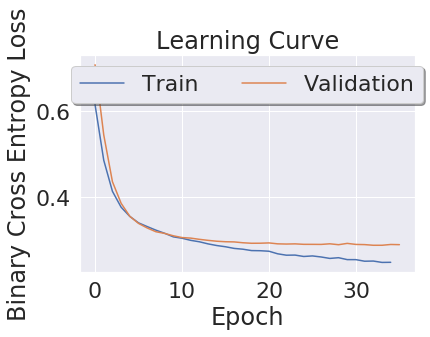

In [22]:
model_trainer.plot_learning_curve()

In [23]:
feature_extractor_probs, feature_extractor_decs = model_trainer.produce_predictions(val_loader, threshold=0.5, test=False)
y_pred_feature_extractor = feature_extractor_decs.iloc[:, 1:].values.astype('int64')

Producing Outputs: 100%|██████████| 67/67 [00:06<00:00, 12.32it/s]


In [24]:
utils.print_model_metrics(y_pred_feature_extractor, y_true)

Hamming Loss: 12.02%

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.85      0.77      0.81       798
           2       0.76      0.69      0.72       740

   micro avg       0.80      0.69      0.75      1623
   macro avg       0.54      0.49      0.51      1623
weighted avg       0.76      0.69      0.73      1623
 samples avg       0.42      0.41      0.40      1623


One vs. All Confusion Matrices
[[[2051    0]
  [  85    0]]

 [[1229  109]
  [ 185  613]]

 [[1232  164]
  [ 227  513]]]


Interesting to note is that our model definitely shows signs of significant improvement over our dummy classifier with both our selected metric of micro avg recall as well as Hamming loss. However, also worth pointing out is the complete failure to recall the class 0, epidural. We noted earlier that this might be a challenge due to the class imbalance. We will seek to combat this issue in the next stage of the report.

## Ablation Studies
In order to combat with the issue of imbalanced classes, I propose two mutually exclusive strategies:
1. Weight each class inversely proportionately to how frequently it occurs in the dataset - For example, if one has two classes, and one class is twice as frequent as the other, then the under-represented class would have a weight twice that of the over-represented class. These weights can be applied directly to our BCE loss function using the pos_weight parameter. Note that this will change the loss value and will make direct comparisons of BCE loss between this model and baseline model #2 unreasonable.
2. Oversample under-represented classes in our training data set until they occur at the same frequency as the other classes. Note that we will not be weighting the classes differently with our loss function under this approach, and we will also not be oversampling the validation data set so that we can get appropriate classification metrics with which to compare models.

We will also experiment with fine-tuning additional layers of our backbone ResNeXt model. For the sake of this experiment, we will unfreeze the final block of layers, but further experimentation should be done to try unfreezing larger amounts of the network. This, along with other potential next steps, will be discussed in the final section.

### Store previous model
In order to conserve RAM space, we will be storing our baseline model 1 to disk and deleting it from memory:

In [25]:
model_trainer.save('logs/models/baseline_feature_extractor.pkl')
del model_trainer

### First experiment - Unfreeze final block
Our first experiment will differ from the feature extractor baseline in that fewer layers are frozen. Let's set this model up and train it:

In [26]:
loss_fn = nn.BCEWithLogitsLoss()

pretrained_model = models.resnext101_32x8d(pretrained=True)
model_trainer = FineTuneTrainer(pretrained_model=pretrained_model, device=DEVICE, num_classes=NUM_CLASSES, loss_fn=loss_fn, lr=LR, fp16="O1")
model_trainer.freeze_first_n_trainable_layers(trainable_layers={'Conv2d', 'Linear'}, n=97)

model_trainer.train_model(train_loader=train_loader,
                          val_loader=val_loader,
                          num_epochs=NUM_EPOCHS,
                          val_freq=VAL_FREQ,
                          grad_accum_steps=GRAD_ACCUM_STEPS,
                          eval_first=True,
                          early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch: 1 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Freezing parameters for layer: ResNet - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequent

Epoch: 2 Validation: 100%|██████████| 67/67 [00:06<00:00, 11.04it/s, Loss: 0.5476]
/home/aj/miniconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: 4 Training:   0%|          | 1/201 [00:00<02:41,  1.24it/s, Loss: 0.3334]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 14 Training:   0%|          | 1/201 [00:00<02:43,  1.22it/s, Loss: 0.3342]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 19 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 29 Training:  15%|█▍        | 30/201 [00:10<00:58,  2.94it/s, Loss: 0.2546]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 34 Validation: 100%|██████████| 67/67 [00:06<00:00, 12.42it/s, Loss: 0.2949]


Early stopping with patience 5 triggered at epoch 33.
Training complete. Total training time: 42.35m
Best model occurred at epoch 29. Reloading weights from this checkpoint.


In [27]:
model_1_probs, model_1_decs = model_trainer.produce_predictions(val_loader, test=False)
y_pred_model_1 = model_1_decs.iloc[:, 1:].values.astype('int64')
utils.print_model_metrics(y_pred_model_1, y_true)

Producing Outputs: 100%|██████████| 67/67 [00:06<00:00, 10.95it/s]

Hamming Loss: 12.16%

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.83      0.79      0.81       798
           2       0.75      0.68      0.71       740

   micro avg       0.80      0.70      0.74      1623
   macro avg       0.53      0.49      0.51      1623
weighted avg       0.75      0.70      0.72      1623
 samples avg       0.42      0.42      0.41      1623


One vs. All Confusion Matrices
[[[2051    0]
  [  85    0]]

 [[1213  125]
  [ 166  632]]

 [[1232  164]
  [ 239  501]]]


### Commentary on results of first model experiment
The Hamming Loss here is similar to that of the feature extractor baseline, and so is the micro avg recall. This model also fails to even attempt to classify the epidural condition. Essentially, this model is quite similar to the baseline model. It's possible that unfreezing and testing more layers could be beneficial.

In [28]:
model_trainer.save('logs/models/experiment_1_unfreeze_final_block.pkl')
del model_trainer

### Second experiment - Apply class weightings
Our second experiment will weight classes inversely proportionately to how frequently they occur in the data set. I wrote a simple util function to automatically calculate the appropriate weights based on their frequencies. These weights are then normalized so that the weights add up to 3 (for 3 classes). Let's let it run and make sure it is working as intended:

In [29]:
class_weights = utils.build_class_weights(training_data.labels)
print(class_weights)
print(training_data.labels.iloc[:, 1:].sum().values)

(2.454282247274659, 0.2624462219307906, 0.28327153079455036)
[ 256 2394 2218]


Now that we have appropriate class weights, all we need to do to run our experiment is re-initialize the loss function with the class weights and train as normal:

In [30]:
class_weights = utils.build_class_weights(training_data.labels)
loss_fn = nn.BCEWithLogitsLoss(torch.Tensor(class_weights).to(DEVICE))

pretrained_model = models.resnext101_32x8d(pretrained=True)
model_trainer = FineTuneTrainer(pretrained_model=pretrained_model, device=DEVICE, num_classes=NUM_CLASSES, loss_fn=loss_fn, lr=LR, fp16="O1")
model_trainer.freeze_first_n_trainable_layers(trainable_layers={'Conv2d', 'Linear'}, n=97)

model_trainer.train_model(train_loader=train_loader,
                          val_loader=val_loader,
                          num_epochs=NUM_EPOCHS,
                          val_freq=VAL_FREQ,
                          grad_accum_steps=GRAD_ACCUM_STEPS,
                          eval_first=True,
                          early_stopping_patience=EARLY_STOPPING_PATIENCE)

Epoch: 1 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Freezing parameters for layer: ResNet - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequent

Epoch: 2 Validation: 100%|██████████| 67/67 [00:06<00:00, 10.99it/s, Loss: 0.3894]
/home/aj/miniconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: 2 Training:  15%|█▌        | 31/201 [00:11<00:59,  2.84it/s, Loss: 0.3625]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 5 Training:  40%|███▉      | 80/201 [00:28<00:42,  2.86it/s, Loss: 0.2137]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 10 Training:  91%|█████████ | 183/201 [01:05<00:06,  2.90it/s, Loss: 0.1813]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Epoch: 17 Training:  62%|██████▏   | 124/201 [00:44<00:26,  2.90it/s, Loss: 0.1488]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Epoch: 28 Validation: 100%|██████████| 67/67 [00:06<00:00, 12.37it/s, Loss: 0.1912]


Early stopping with patience 5 triggered at epoch 27.
Training complete. Total training time: 35.09m
Best model occurred at epoch 23. Reloading weights from this checkpoint.


In [31]:
class_weightings_probs, class_weightings_decs = model_trainer.produce_predictions(val_loader, test=False)
y_pred_model_2 = class_weightings_decs.iloc[:, 1:].values.astype('int64')
utils.print_model_metrics(y_pred_model_2, y_true)

Producing Outputs: 100%|██████████| 67/67 [00:06<00:00, 12.31it/s]


Hamming Loss: 13.84%

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        85
           1       0.80      0.73      0.76       798
           2       0.73      0.64      0.69       740

   micro avg       0.77      0.65      0.71      1623
   macro avg       0.62      0.48      0.52      1623
weighted avg       0.75      0.65      0.69      1623
 samples avg       0.37      0.38      0.36      1623


One vs. All Confusion Matrices
[[[2041   10]
  [  80    5]]

 [[1196  142]
  [ 218  580]]

 [[1222  174]
  [ 263  477]]]


### Commentary on results of second model experiment
This model has a worse hamming loss and micro avg recall than the prior two models. However, it does succeed in classifying 5 of the 85 occurrences of epidural, resulting in a positive recall (but still fairly poor recall compared to the other two classes). If we were more interested in having some recall versus none for epidural, this model would be superior over the prior two, but if we are treating each condition equally, I would argue that the sacrifice made to improve the quality of predictions for epidural does not outweigh what is lost in the quality of predictions for the other two conditions.

In [32]:
model_trainer.save('logs/models/experiment_2_class_weightings.pkl')
del model_trainer

### Third experiment - Oversampling
For our third and final experiment, we will apply oversampling to our training data set to even out the frequency of each class. This can be done via a method I built in to the data set class that will continuously resample from our labels to put together an order of images until the frequency of each image is within a set threshold of each other. I did my best to avoid bias in the way I wrote the code. Let's check it out to make sure it is working as intended:

In [25]:
training_data_oversample = ImageDataset(idxs=train_indices.values,
                                        csv_file=CSV_FILE,
                                        root_dir='data/wetransfer-1c7414/train_images',
                                        transform=training_transform,
                                        oversample=True)
train_loader_oversample = DataLoader(training_data_oversample,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
print(f'Frequency of each class in original training set: {training_data.labels.iloc[:, 1:].values.sum(0)}')
print(f'Frequency of each class in oversampled training set: {training_data_oversample.labels.iloc[:, 1:].values.sum(0)}')

print(f'Length of original training set: {len(training_data)}')
print(f'Length of oversampled training set: {len(training_data_oversample)}')

Frequency of each class in original training set: [ 256 2394 2218]
Frequency of each class in oversampled training set: [3634 3639 3634]
Length of original training set: 6406
Length of oversampled training set: 10260


This oversampling will be re-performed each epoch in order to increase variability in our data set:

In [34]:
training_data_oversample.reapply_oversample()
len(training_data_oversample)

10674

Now that we have verified that the oversampling works as intended, let's proceed to train the third model:

In [26]:
loss_fn = nn.BCEWithLogitsLoss()

pretrained_model = models.resnext101_32x8d(pretrained=True)
model_trainer = FineTuneTrainer(pretrained_model=pretrained_model, device=DEVICE, num_classes=NUM_CLASSES, loss_fn=loss_fn, lr=LR, fp16="O1")
model_trainer.freeze_first_n_trainable_layers(trainable_layers={'Conv2d', 'Linear'}, n=97)

model_trainer.train_model(train_loader=train_loader,
                          val_loader=val_loader,
                          num_epochs=NUM_EPOCHS,
                          val_freq=VAL_FREQ,
                          grad_accum_steps=GRAD_ACCUM_STEPS,
                          eval_first=True,
                          early_stopping_patience=EARLY_STOPPING_PATIENCE,
                          oversample=True)

Epoch: 1 Validation:   0%|          | 0/67 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Freezing parameters for layer: ResNet - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequential - Bottleneck - Conv2d
Freezing parameters for layer: ResNet - Sequent

Epoch: 2 Validation: 100%|██████████| 67/67 [00:06<00:00, 12.51it/s, Loss: 0.5252]
/home/aj/miniconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: 2 Training:  34%|███▎      | 110/328 [00:42<01:26,  2.52it/s, Loss: 0.5329]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch: 4 Training:  57%|█████▋    | 188/331 [01:07<00:48,  2.96it/s, Loss: 0.4123]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 10 Training:  70%|██████▉   | 229/328 [01:23<00:36,  2.71it/s, Loss: 0.2792]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Epoch: 11 Training:  12%|█▏        | 39/331 [00:14<01:40,  2.92it/s, Loss: 0.2660]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Epoch: 23 Validation: 100%|██████████| 67/67 [00:06<00:00, 10.51it/s, Loss: 0.3038]

Early stopping with patience 5 triggered at epoch 22.
Training complete. Total training time: 47.5m
Best model occurred at epoch 18. Reloading weights from this checkpoint.


In [109]:
oversample_probs, oversample_decs = model_trainer.produce_predictions(val_loader, test=False)
y_pred_model_3 = oversample_decs.iloc[:, 1:].values.astype('int64')
utils.print_model_metrics(y_pred_model_3, y_true)

Producing Outputs: 100%|██████████| 67/67 [00:06<00:00, 10.78it/s]

Hamming Loss: 12.53%

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.18      0.23        85
           1       0.84      0.79      0.81       798
           2       0.73      0.70      0.72       740

   micro avg       0.77      0.72      0.74      1623
   macro avg       0.63      0.56      0.59      1623
weighted avg       0.76      0.72      0.74      1623
 samples avg       0.41      0.42      0.40      1623


One vs. All Confusion Matrices
[[[2019   32]
  [  70   15]]

 [[1218  120]
  [ 170  628]]

 [[1205  191]
  [ 220  520]]]


### Commentary on results of third model experiment
It looks like the oversampling trick was effective. This model achieved the highest micro avg recall score, due to a significantly higher recall for the epidural class. This increase in recall came at the cost of a reduction in precision, but it does not appear that performance on the other classes suffered to compensate. Based on these findings, I will select this third experiment as the final model for use in generating predictions on the test set.

In [28]:
model_trainer.save('logs/models/experiment_3_oversampling.pkl')
del model_trainer

## Summary of numerical model results
Below is a quick snapshot summarizing the results and allowing for a quick comparison of the prior discussed models.

In [107]:
x = PrettyTable()

x.field_names = ["Model", "Micro Recall", "Micro F1", "0 Recall", "1 Recall", "2 Recall", "Hamming Loss"]
x.add_row(["Baseline #1: Dummy", "34%", "35%", "8%", "36%", "35%", "33%"])
x.add_row(["Baseline #2: Feature Extractor", "69%", color.BOLD + color.RED + "75%" + color.END, "0%", "77%", "69%", color.BOLD + color.RED + "12%" + color.END])
x.add_row(["Experiment #1: Fine Tune Final Block", "70%", "74%", "0%", "79%", "68%", "12%"])
x.add_row(["Experiment #2: Class Weightings", "65%", "71%", "6%", "73%", "64%", "14%"])
x.add_row(["Experiment #3: Oversampling", color.BOLD + color.RED + "72%" + color.END, "74%", color.BOLD + color.RED + "18%" + color.END, color.BOLD + color.RED + "79%" + color.END, color.BOLD + color.RED + "70%" + color.END, "12.5%"])

print(x)

+--------------------------------------+--------------+----------+----------+----------+----------+--------------+
|                Model                 | Micro Recall | Micro F1 | 0 Recall | 1 Recall | 2 Recall | Hamming Loss |
+--------------------------------------+--------------+----------+----------+----------+----------+--------------+
|          Baseline #1: Dummy          |     34%      |   35%    |    8%    |   36%    |   35%    |     33%      |
|    Baseline #2: Feature Extractor    |     69%      |   75%    |    0%    |   77%    |   69%    |     12%      |
| Experiment #1: Fine Tune Final Block |     70%      |   74%    |    0%    |   79%    |   68%    |     12%      |
|   Experiment #2: Class Weightings    |     65%      |   71%    |    6%    |   73%    |   64%    |     14%      |
|     Experiment #3: Oversampling      |     72%      |   74%    |   18%    |   79%    |   70%    |    12.5%     |
+--------------------------------------+--------------+----------+----------+---

### ROC Curves
Another important consideration is determining an appropriate confidence threshold for deterministically identifying model classification. So far we have been using a threshold of 0.5 by default to compare all models on equal footing. As discussed earlier, with medical diagnoses false negatives are more costly than false negatives, so we should reduce the threshold necessary to identify the presence of a class. Without a specific formula establishing the tradeoff in cost between false negatives and false positives, I will use judgement to determine an appropriate threshold that minimizes false negatives without generating too many additional false positives.

ROC Curves are a helpful tool for this analysis. By analyzing a model's ROC as well as a helper function I put together to play with various thresholds, we can easily understand the tradeoff of selecting different thresholds.

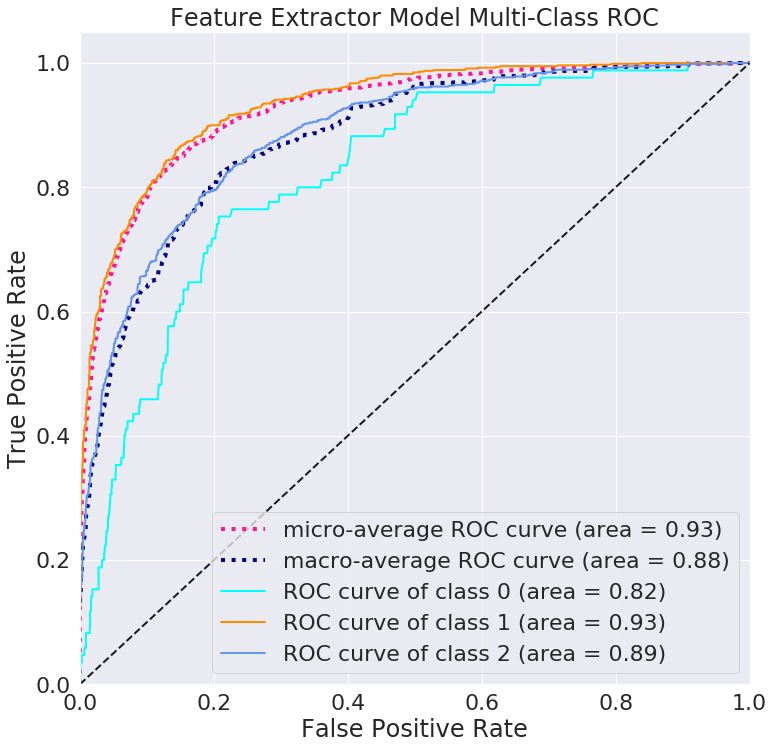

In [102]:
utils.plot_auc(feature_extractor_probs.iloc[:, 1:].values, y_true, "Feature Extractor Model")

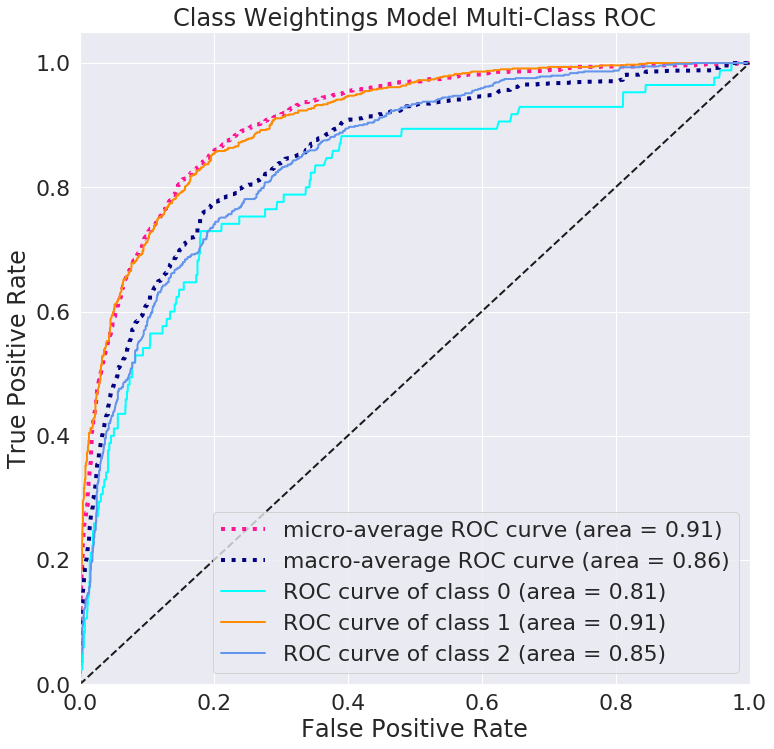

In [104]:
utils.plot_auc(class_weightings_probs.iloc[:, 1:].values, y_true, "Class Weightings Model")

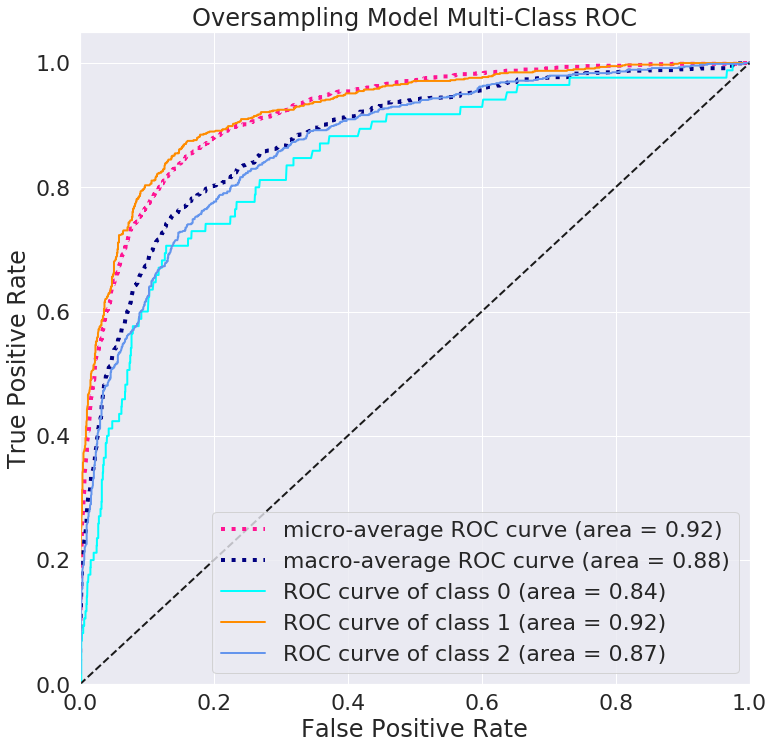

In [110]:
utils.plot_auc(oversample_probs.iloc[:, 1:].values, y_true, "Oversampling Model")

In [118]:
test_threshold(feature_extractor_probs, y_true, 0.3)

Hamming Loss: 12.94%

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        85
           1       0.79      0.84      0.81       798
           2       0.67      0.81      0.73       740

   micro avg       0.73      0.78      0.75      1623
   macro avg       0.65      0.55      0.52      1623
weighted avg       0.72      0.78      0.74      1623
 samples avg       0.42      0.46      0.43      1623


One vs. All Confusion Matrices
[[[2050    1]
  [  84    1]]

 [[1154  184]
  [ 124  674]]

 [[1103  293]
  [ 143  597]]]


In [134]:
test_threshold(oversample_probs, y_true, 0.3)

Hamming Loss: 15.04%

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.27      0.28        85
           1       0.75      0.88      0.81       798
           2       0.61      0.85      0.71       740

   micro avg       0.66      0.83      0.74      1623
   macro avg       0.55      0.67      0.60      1623
weighted avg       0.66      0.83      0.74      1623
 samples avg       0.41      0.49      0.43      1623


One vs. All Confusion Matrices
[[[1993   58]
  [  62   23]]

 [[1110  228]
  [  99  699]]

 [[ 990  406]
  [ 111  629]]]


In the absence of additional information, I am going to opt for a threshold of 0.3, as this value does not sacrifice F1 score, but increases our micro avg recall from 72% to 83%. Furthermore, the Hamming loss only drops 2.5%.

### Preparation of submission

In [123]:
model_trainer = utils.load_model_trainer('logs/models/experiment_3_oversampling.pkl')
test_data = ImageDataset(root_dir='data/wetransfer-1c7414/test_images',
                         transform=val_transform)
test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

test_prob, test_dec = model_trainer.produce_predictions(test_loader, threshold=0.3)
test_prob.to_csv('binary_probabilities.csv', index=False)
test_dec.to_csv('binary_predictions.csv', index=False)

Producing Outputs: 100%|██████████| 126/126 [00:11<00:00, 12.58it/s]


It is interesting to compare the distribution of predictions on the training set versus the test set. Let's do a quick comparison of this with our final selected model.

In [124]:
val_prob, val_dec = model_trainer.produce_predictions(val_loader, test=False, threshold=0.3)

Producing Outputs: 100%|██████████| 67/67 [00:06<00:00, 10.45it/s]


Predictions from final model on test set


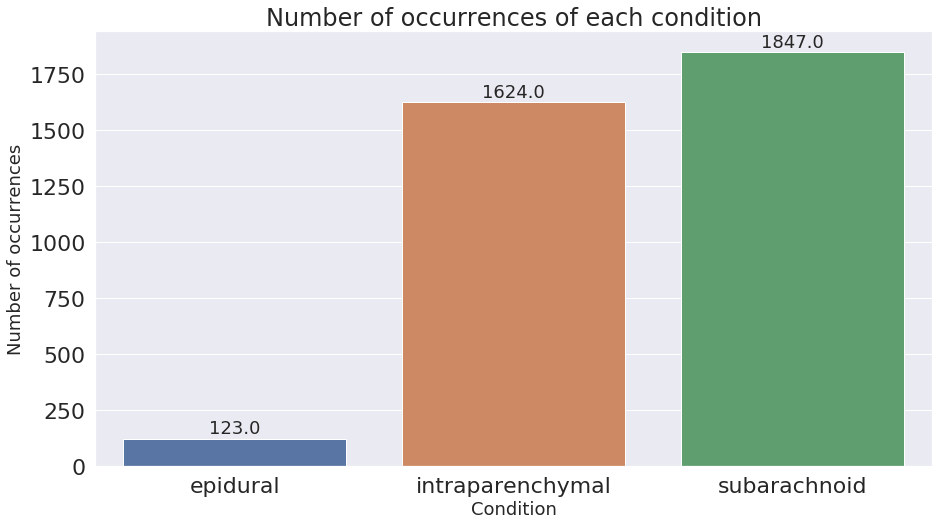

In [125]:
print("Predictions from final model on test set")
utils.bar_plot_condition_occurrences(test_dec)

Predictions from final model on validation set


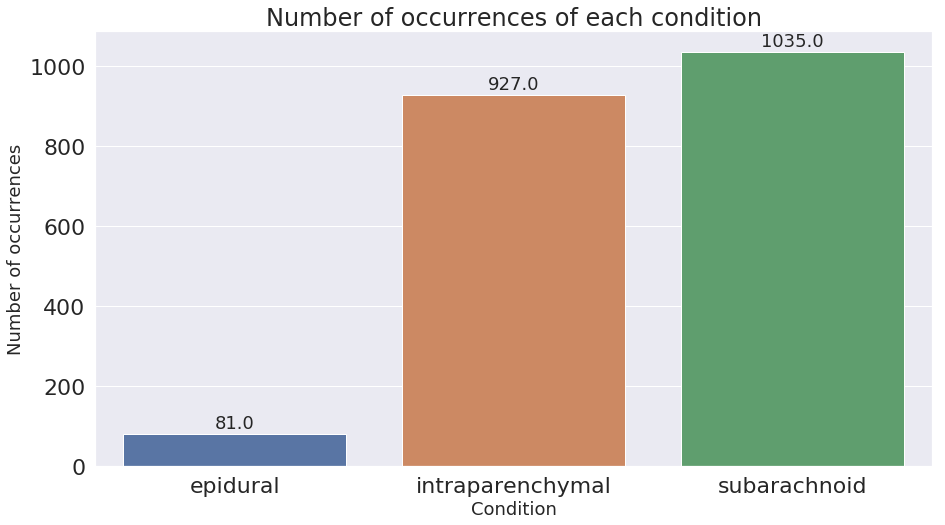

In [126]:
print("Predictions from final model on validation set")
utils.bar_plot_condition_occurrences(val_dec)

Actual distribution on validation set


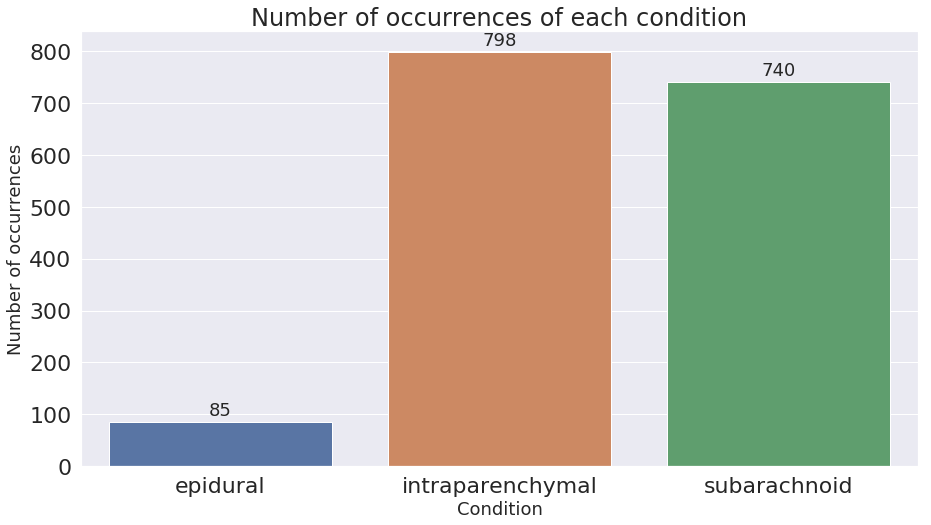

In [127]:
print("Actual distribution on validation set")
utils.bar_plot_condition_occurrences(val_data.labels)

Predicted number of labels on test set


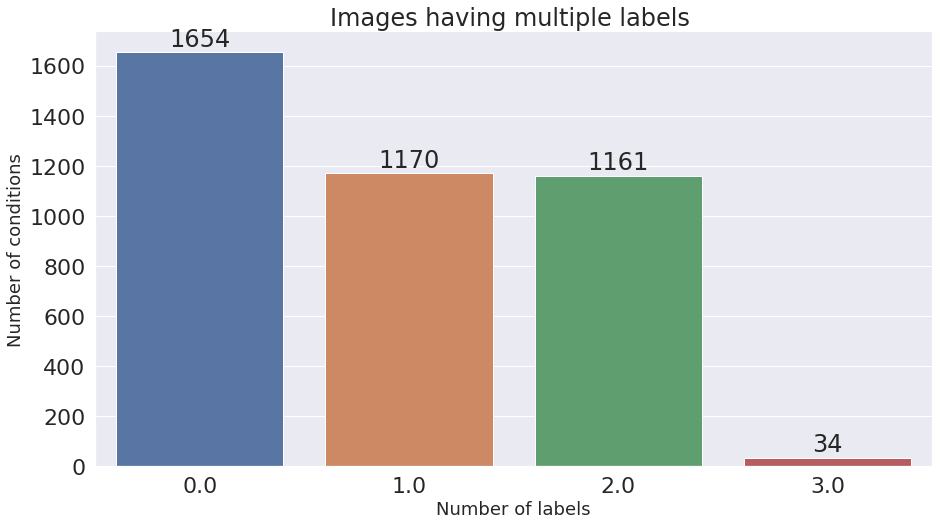

In [128]:
print("Predicted number of labels on test set")
utils.bar_plot_condition_co_occurrences(test_dec)

Predicted number of labels on validation set


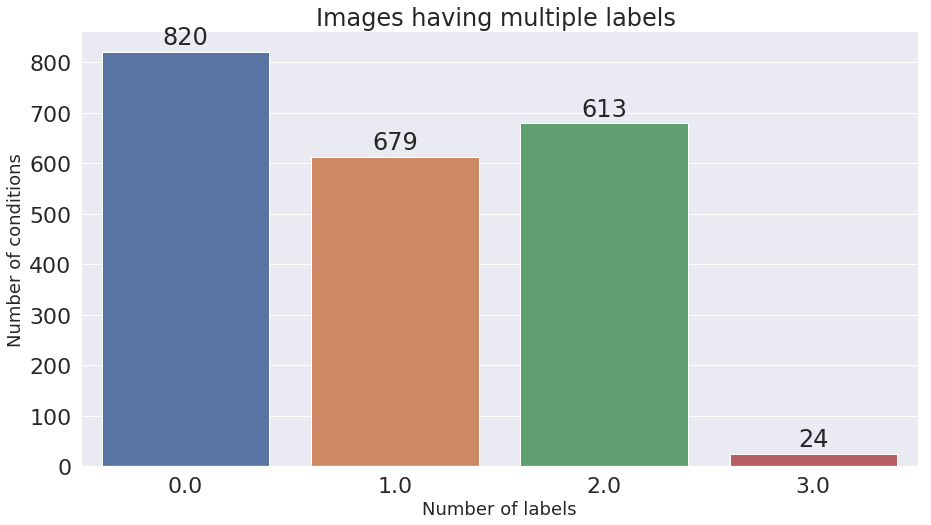

In [129]:
print("Predicted number of labels on validation set")
utils.bar_plot_condition_co_occurrences(val_dec)

Actual number of labels on validation set


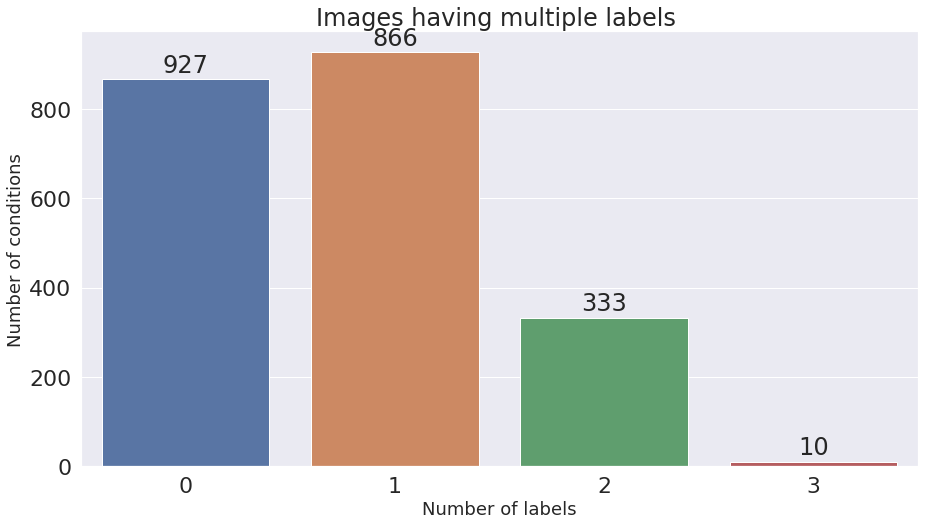

In [130]:
print("Actual number of labels on validation set")
utils.bar_plot_condition_co_occurrences(val_data.labels)

As expected, it seems we are over-predicting occurrences of conditions, but this is desirable for the business. Interestingly, it appears that the subarachnoid class is disproportionately affected.

## Gradient Class Activation Mapping (GradCAM)
GradCAM is a great tool to help diagnose issues with computer vision neural networks. We can use it to gain insight into how a neural network is classifying its examples, and it will be interesting to compare how the different models are classifying certain examples.

In [8]:
full_training_data = ImageDataset(idxs=np.concatenate((train_indices.values, val_indices.values)),
                                  csv_file=CSV_FILE,
                                  root_dir='data/wetransfer-1c7414/train_images',
                                  transform=val_transform)

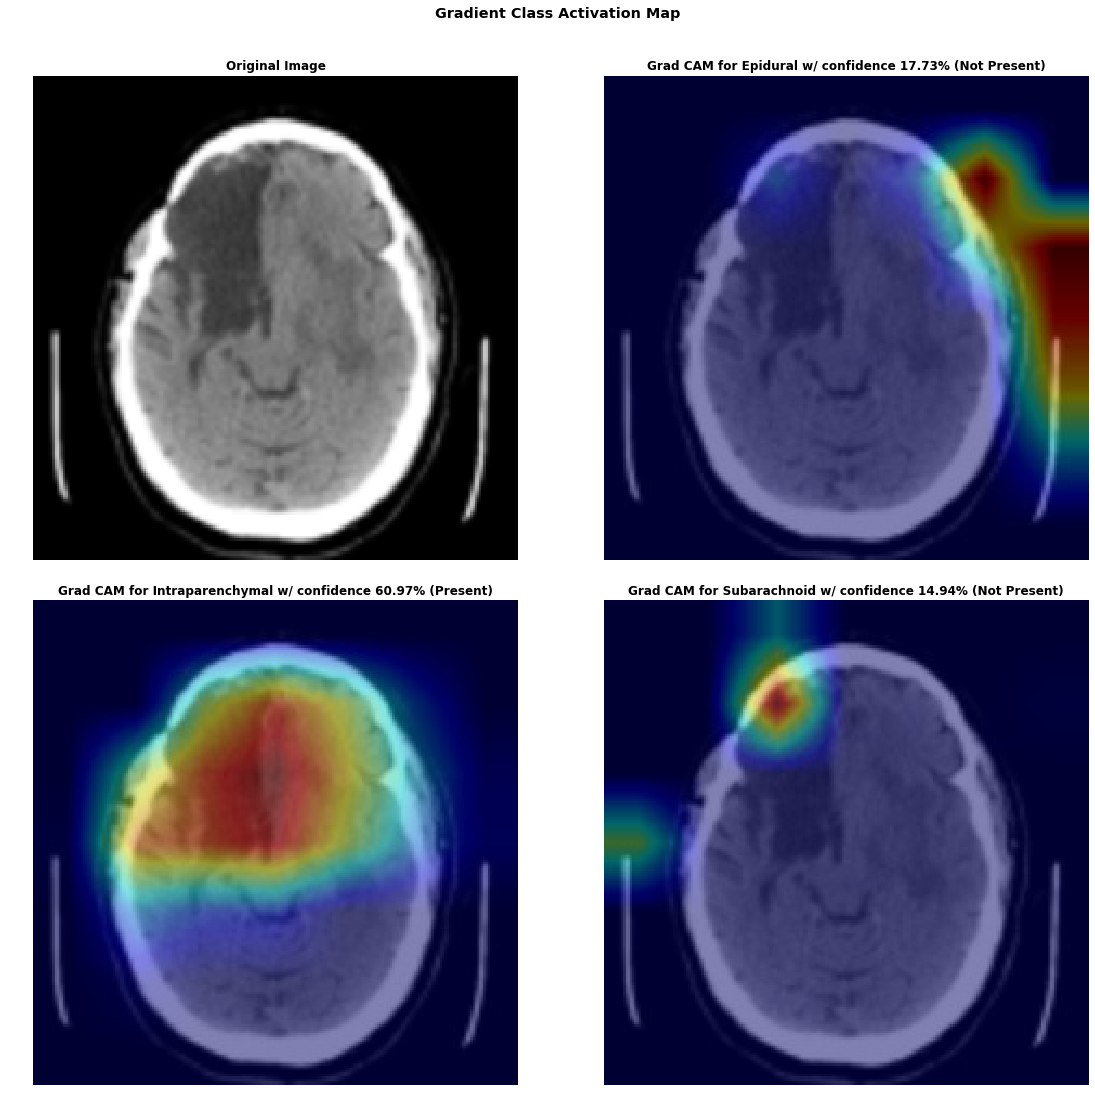

In [9]:
utils.draw_cam(model_trainer_path='logs/models/baseline_feature_extractor.pkl',
               image_dataset=full_training_data,
               image_index=0)

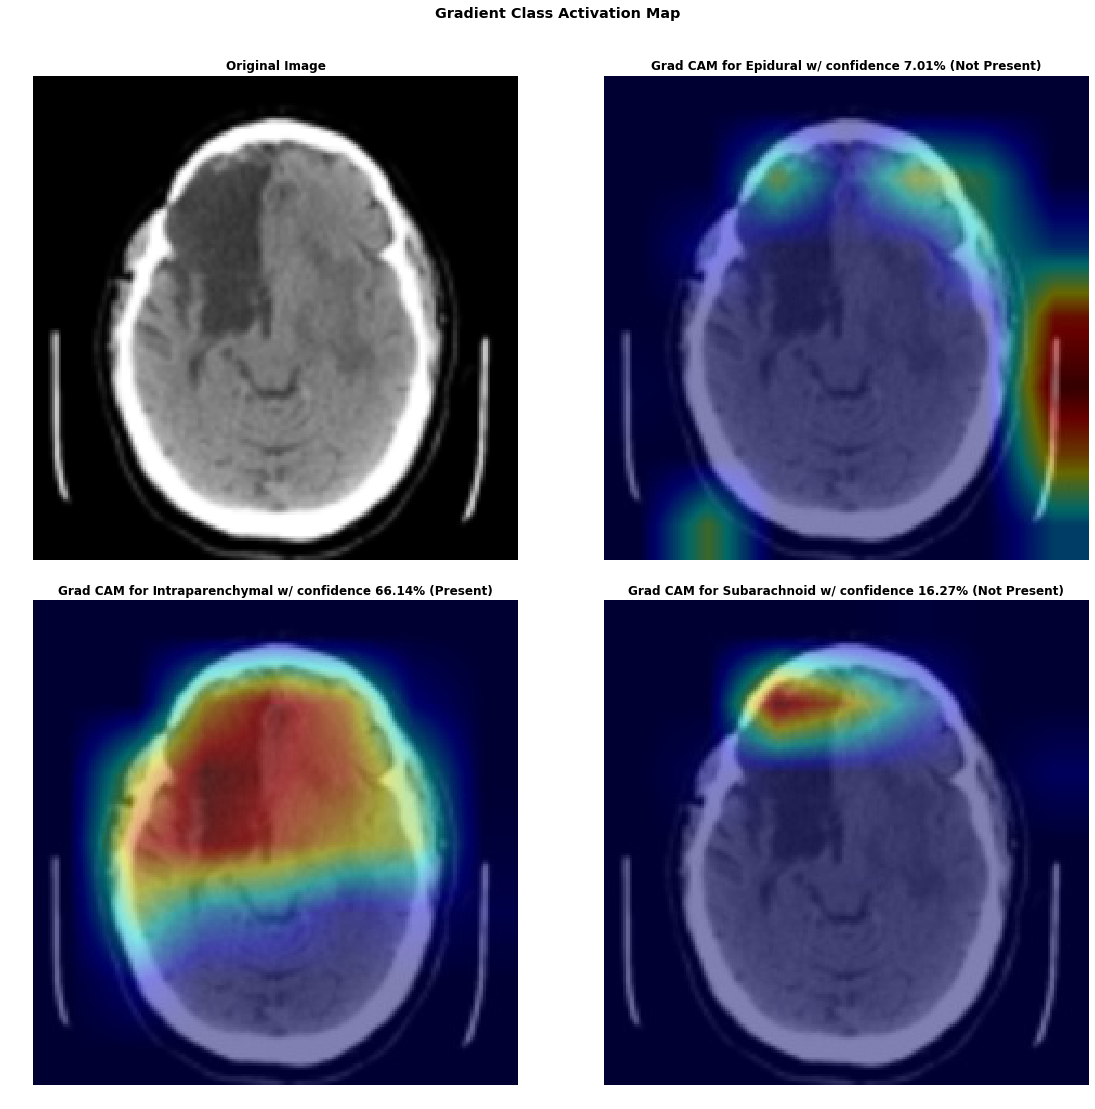

In [10]:
utils.draw_cam(model_trainer_path='logs/models/experiment_2_class_weightings.pkl',
               image_dataset=full_training_data,
               image_index=0)

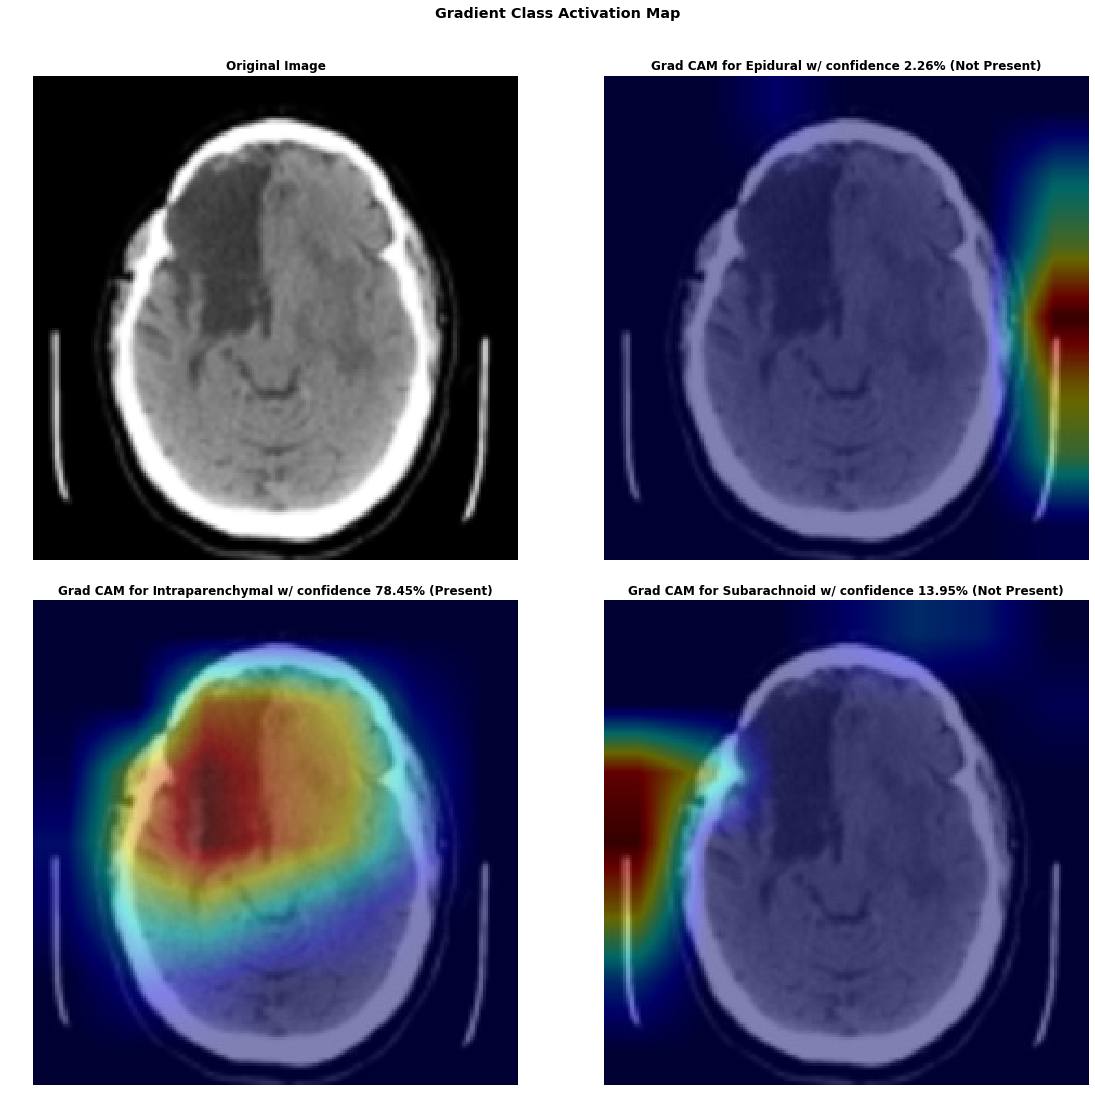

In [11]:
utils.draw_cam(model_trainer_path='logs/models/experiment_3_oversampling.pkl',
               image_dataset=full_training_data,
               image_index=0)

This is an example of the Intraparenchymal class being the only class present. It appears all three networks tested here focus on the same portion of the image to detect whether this class is present.

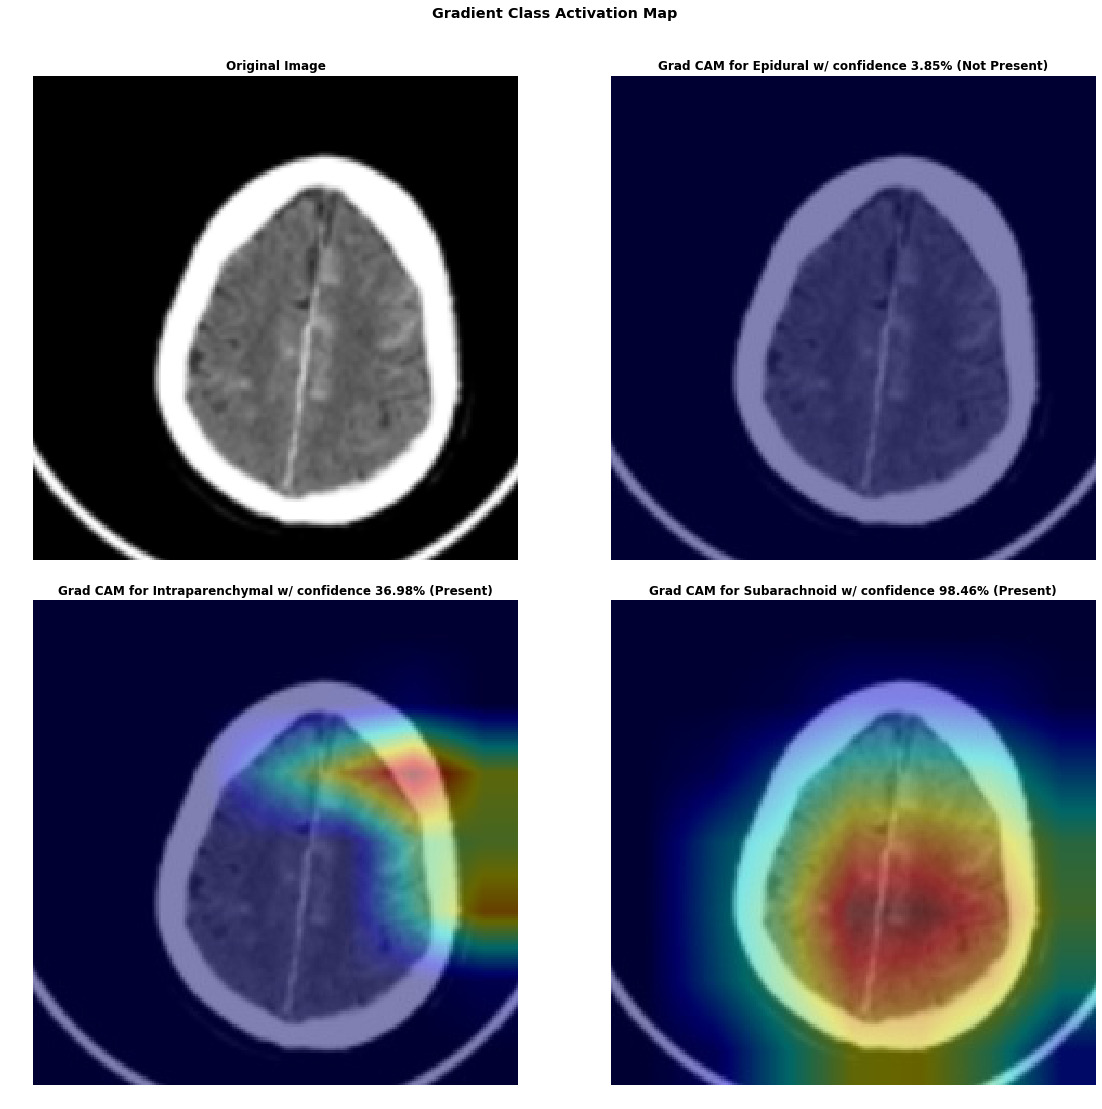

In [12]:
utils.draw_cam(model_trainer_path='logs/models/baseline_feature_extractor.pkl',
               image_dataset=full_training_data,
               image_index=1)

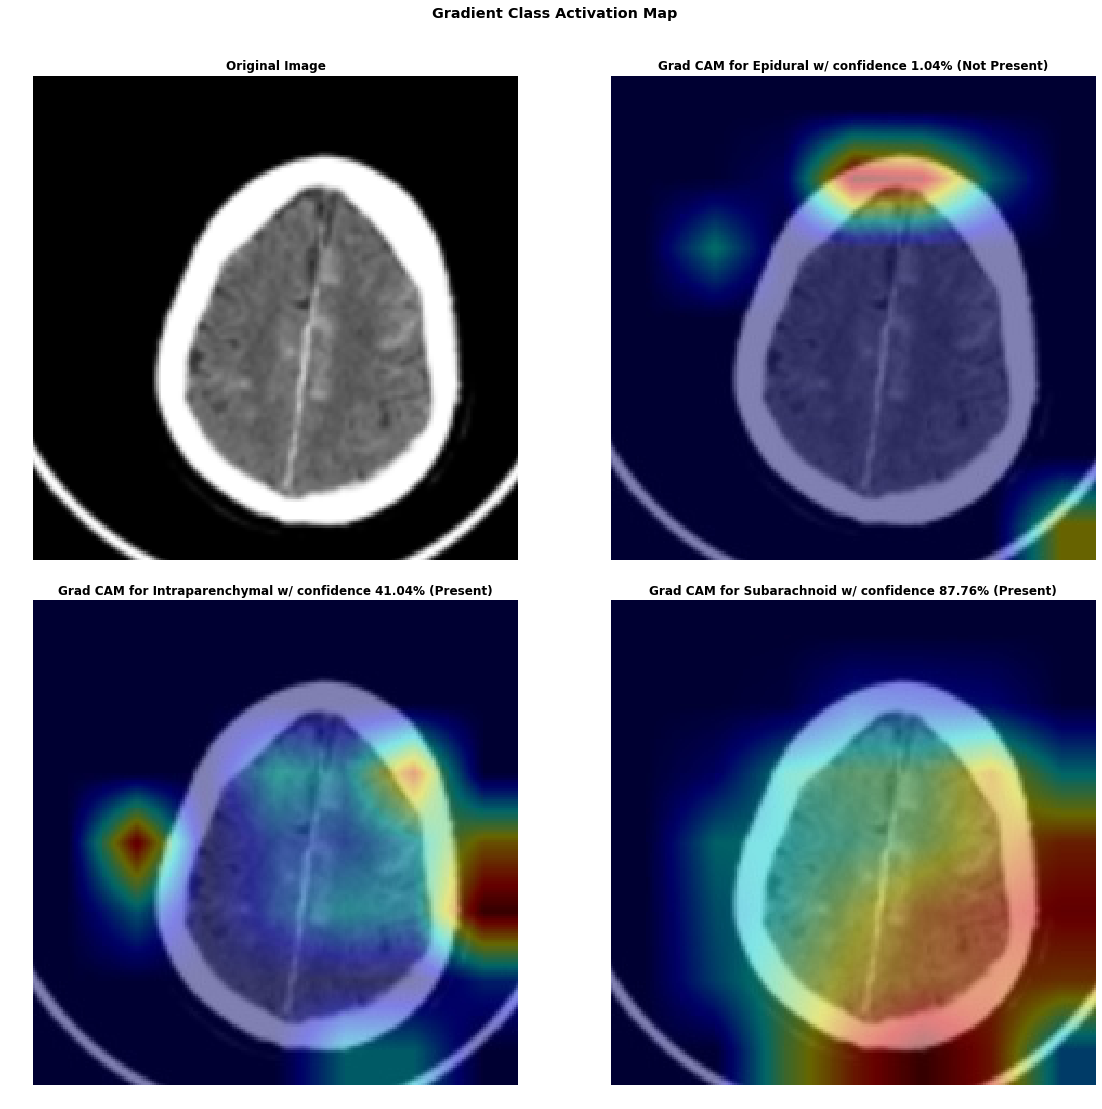

In [13]:
utils.draw_cam(model_trainer_path='logs/models/experiment_2_class_weightings.pkl',
               image_dataset=full_training_data,
               image_index=1)

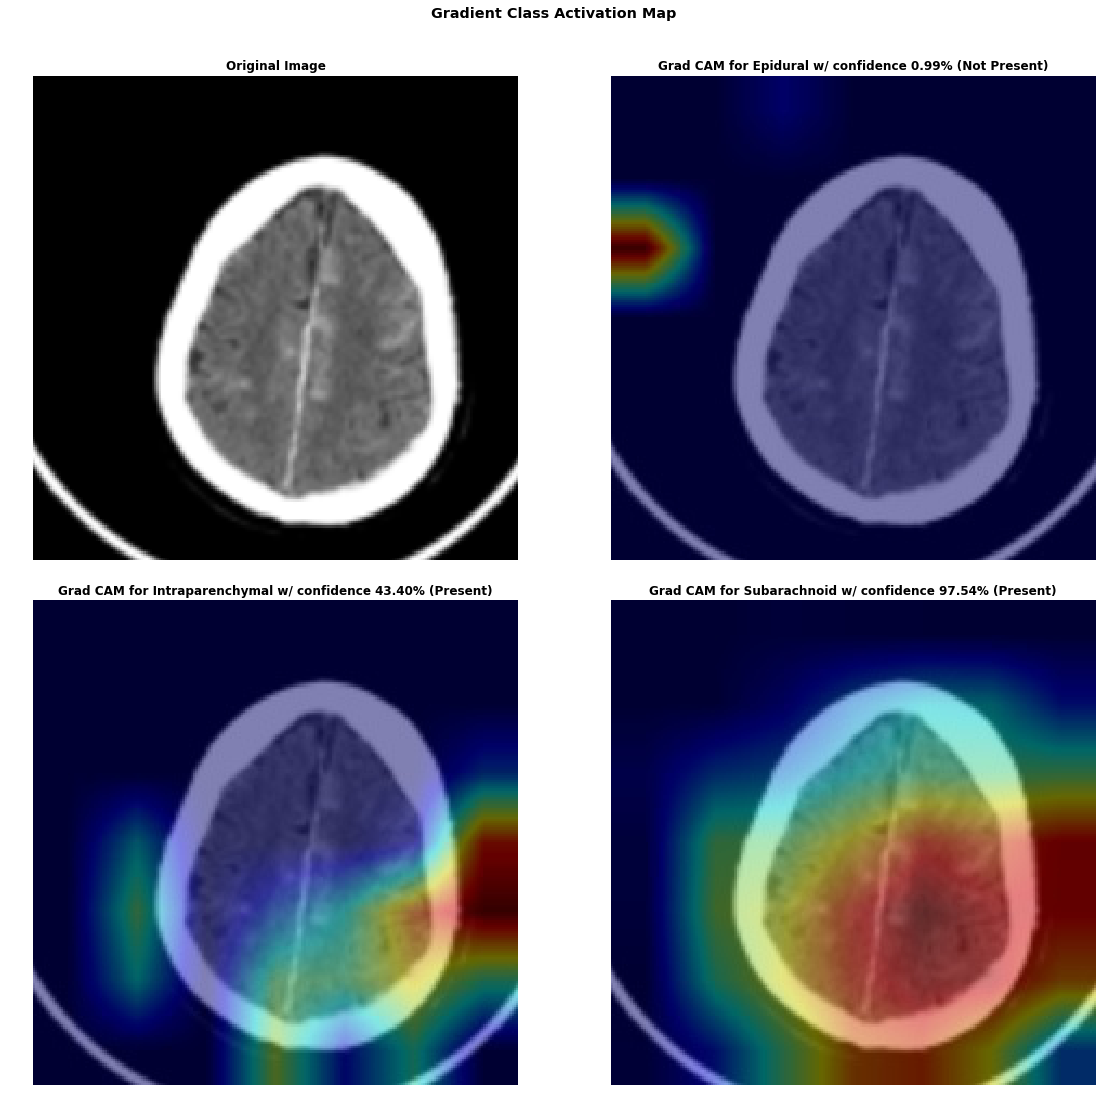

In [14]:
utils.draw_cam(model_trainer_path='logs/models/experiment_3_oversampling.pkl',
               image_dataset=full_training_data,
               image_index=1)

This is an example of all three networks correctly classifying subarachnoid. All three networks focus on the same portion of the image.

Furthermore, with a threshold of 0.3, these networks would correctly classify this image as containing intraparenchymal, but they vary slightly in how they are performing this classification.

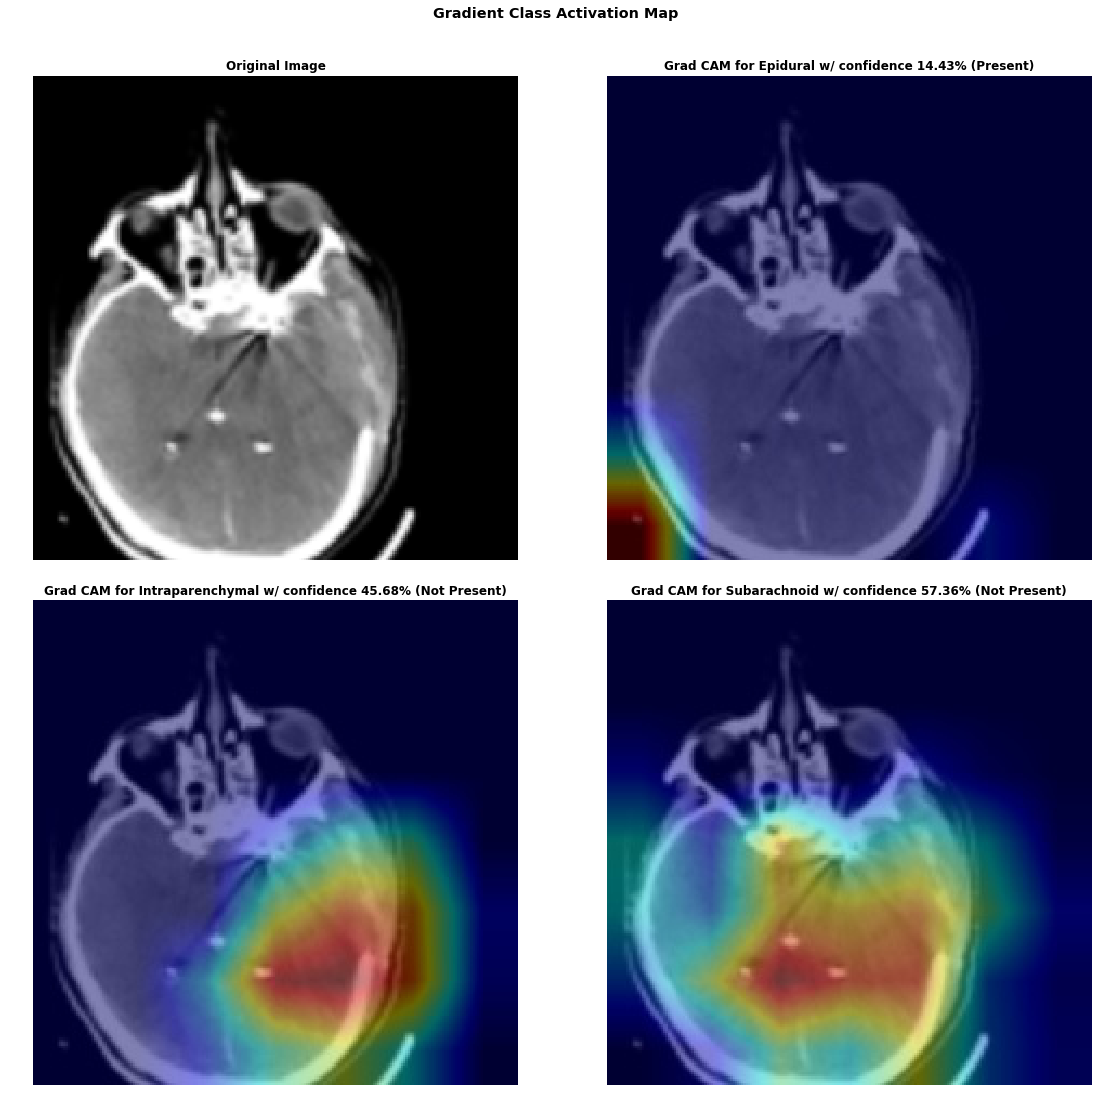

In [33]:
utils.draw_cam(model_trainer_path='logs/models/baseline_feature_extractor.pkl',
               image_dataset=full_training_data,
               image_index=5244)

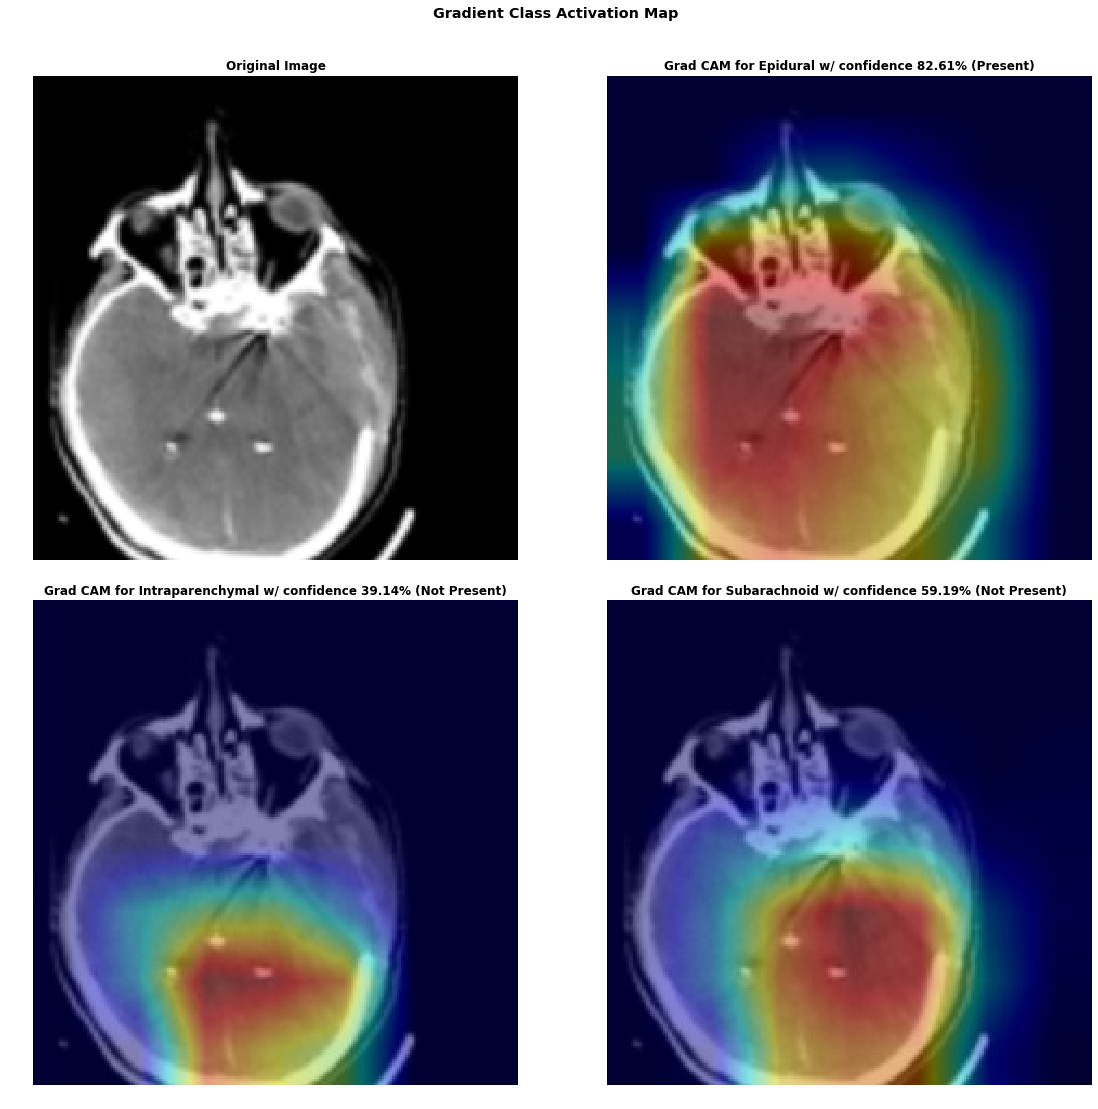

In [32]:
utils.draw_cam(model_trainer_path='logs/models/experiment_2_class_weightings.pkl',
               image_dataset=full_training_data,
               image_index=5244)

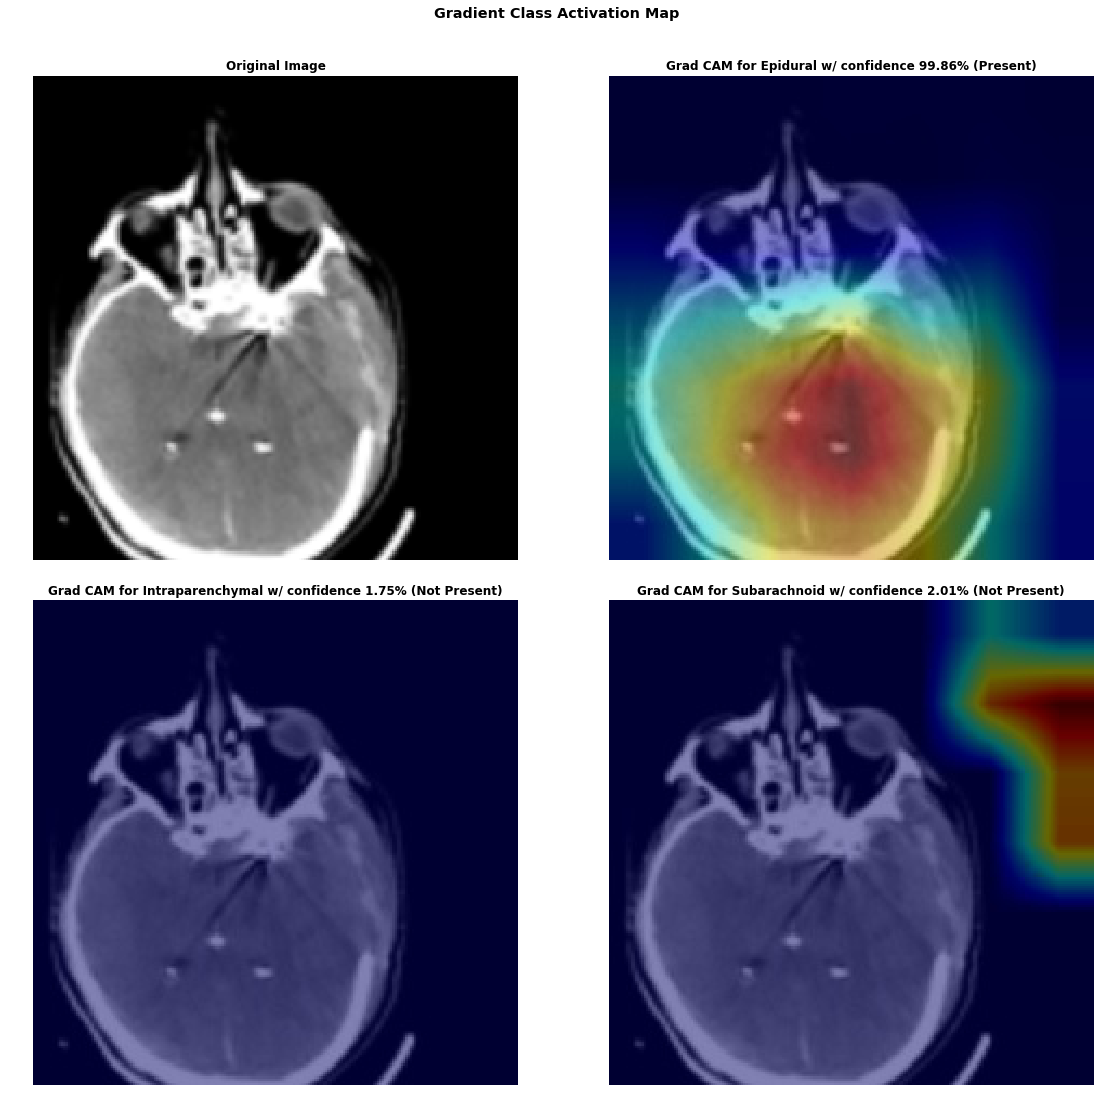

In [31]:
utils.draw_cam(model_trainer_path='logs/models/experiment_3_oversampling.pkl',
               image_dataset=full_training_data,
               image_index=5244)

This is an interesting example for the epidural class. Both networks that have been trained to emphasize epidural correctly classify this image based on the same general area, whereas the baseline model is not able to detect this pattern.

There is a lot more analysis that could be done using GradCAM, I welcome you to play around with it!

## Conclusion
The purpose of this report was to produce a model that could correctly classify the presence of up to three different kinds of ICH, a dangerous type of bleeding that can occur in the brain that requires immediate medical attention. 

This problem can be categorized as a multilabel classification computer vision problem, and due to the nature of the business false negatives are much more expensive than false positives. In other words, it would be much worse if we ignored a patient who actually had one of these conditions than if we incorrectly identified a patient as having the condition. 

In order to select the best performing model, it was important to select a metric to optimize. Based on the argument above, it was decided that micro average recall would be the most important metric, but that micro average F1 score and Hamming loss should be considered as well. The rationale behind also including F1 score and Hamming loss is that while false negatives are more costly than false positives, we should not completely ignore false positives and treat them as costing nothing. A proper balance must exist. In the absence of specific a priori information about this balance, judgement was used.

A brief exploratory data analysis was performed to analyze the distribution of labels and co-occurrence of labels. It was determined that no significant correlation existed between labels, and therefore a loss such as binary cross-entropy would be appropriate and there would be no need for an RNN or attention component of the classifier.

Two baseline models were produced to compare a set of experiments against:
1. A dummy classifier that simply makes random predictions based on the distribution of labels in the training set. 
2. A completely frozen backbone neural network where only the classification layer was trained from scratch. 

One of the biggest challenges of this exercise was class imbalance. The epidural condition occurred approximately 1/10th of the time the other two classes occurred. As a result, several of these models were not sensitive enough to detect the presence of the epidural class. 

Three ablation studies were performed:
1. Unfreeze the final block of the backbone network and fine-tune
2. Employ inversely imbalanced class weights to address the existing class imbalance
3. Employ oversampling so that all classes are represented equally to alternatively address the class imbalance. 

Of all five models produced, the one that employed oversampling turned out to be the best performing model based on the selected metrics. 

Following model selection, a confidence threshold needed to be selected. The default confidence threshold is 0.5, but lowering this threshold further improved our selected metric of micro average recall. Through ROC analysis, a threshold of 0.3 was selected, which resulted in a micro average recall of 83%, a micro average F1 score of 74%, and a Hamming loss of 15%. In other words, on average, when a condition occurs in an image, it is correctly identified 83% of the time. The Hamming loss is essentially an accuracy metric for multilabel classification and implies that we incorrectly classify 15% of total labels. Reducing the confidence threshold from 0.5 to 0.3 increased the micro average recall from 72% to 83%, but only increased the Hamming loss from 12.5% to 15% and kept the F1 score constant.

Based on the selected model and threshold, classification outputs (both probabilistic and deterministic) were produced.

The final step in this analysis was studying gradient class activation mapping (GradCAM). This is an insightful method to visualize how computer vision neural networks make decisions, and can shed light on potential reasons why the network is making mistakes that can be addressed in future model iterations.

## Next Steps
Due to the time constraints inherent in solving this problem, there are several items left unaddressed that future experimentation could consider focusing on. Please find a summary below:
1. Experiment with SGD w/ Nesterov momentum instead of the Adam optimizer: I find that while the Adam optimizer is much quicker to tune and fit than SGD, it also tends to overfit and produce potentially underperforming models. Adam was selected here for the sake of faster experimentation and iteration, but it is plausible that using SGD could result in a higher quality final model.

2. Employ cross-validation or train a final model on the entire data set, rather than just a training-validation split. This was not done due to time constraints and to simplify the problem.

3. Analyze gradient norms/histograms of neural network parameters to get a better idea of training history and whether the training schedule of the model should be adjusted. Ideas include cyclical loss rates, different batch sizes, different clipping of gradient norms vs. not clipping gradient norms, etc.

4. Only one backbone network, ResNeXt, was used here. I would be interested to see how other high-performing, traditional backbone networks would perform on this problem.

5. Only one unfreezing strategy was attempted here. It would be interesting to see if unfreezing more of the backbone network could improve performance.

6. Only one data augmentation scheme was attempted. It is possible this data augmentation scheme is sub-optimal, and further experimentation could be done with different data augmentations.

7. A single confidence threshold was selected for all three classes. It is plausible that selecting a different confidence threshold for each class would result in better business performance.

8. Additional analysis should be performed on the results of GradCAM. It may give insight into augmentations that can be performed, images that should be discarded from the data set, and additional types of images that should be collected to improve model performance. Not only this, but it could also give insight to doctor's to better understand warning signs of ICH.

9. Having a better understanding of the tradeoff between false negatives and false positives could result in a more appropriate metric for performing model and threshold selection.

10. Gaining an additional benchmark of a highly skilled doctor to compare against this model's performance would be very interesting.